# Climate and air-quality benefits of a realistic phase-out of fossil fuels

This notebook provides the processing code and figures for "Climate and air-quality benefits of a realistic phase-out of fossil fuels".

## Requirements

The notebook below should work with a reasonably standard Python environment with a few well-used additional modules, notably numpy, scipy, pandas, netCDF4 and matplotlib. The one exception is the FaIR simple climate model, which is available on PyPI at https://pypi.org/project/fair/ (follow the installation instructions there) or on GitHub at https://github.com/OMS-NetZero/FAIR. The version used in the paper is 1.3.6. Some of the processing cells take a reasonably long time, so to track progress I use tqdm_notebook.

This notebook was produced using Python 2.7. Python 3.x should work subject to re-writing the `print` statements, but has not been tested.

## Notes

This notebook was originally produced using emissions scenarios files provided in MAGICC6 SCEN format for the IPCC's Special Report on Global Warming of 1.5C. These files are not in the public domain. However, the emissions files are very similar (subject to unit conversion scaling factors, rounding errors, and in a couple of cases apparent mis-harmonization) to the `Diagnostics|MAGICC6|Harmonized Input|Emissions` timeseries available on the IAMC Scenario Explorer at https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/. This notebook therefore uses these publicly available emissions files, a subset of which are downloaded into the `input_data/emissions/` directory. It should therefore be noted that **data produced using these alternative emissions files will not be exactly the same as that appearing in the paper**. However, using these alternative emissions files does not change any conclusions.

Please feel free to raise pull requests and issues on this code.

~ Chris Smith, 19.09.2019

In [1]:
# Required imports
import copy
import errno
import matplotlib.pyplot as pl
import numpy as np
import operator
import os
import pandas as pd
import scipy.stats as st
from matplotlib import gridspec, rc
from matplotlib.ticker import MultipleLocator
from netCDF4 import Dataset
from scipy.interpolate import interp1d
from scipy.optimize import root
from tqdm import tqdm_notebook
from fair.tools.magicc import scen_open
from fair.constants import molwt
from fair.constants.general import ppm_gtc
from fair.forward import fair_scm
from fair.ancil import natural
from fair.RCPs import rcp3pd

In [2]:
# House style for plotting
%matplotlib inline
pl.rcParams['font.size'] = 7
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.direction'] = 'in'
pl.rcParams['ytick.direction'] = 'in'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['figure.dpi'] = 300
pl.rcParams['axes.axisbelow'] = False
pl.rcParams['figure.figsize'] = [16, 16]

In [3]:
# incredibly useful function for creating output directories - thanks to https://stackoverflow.com/questions/600268/mkdir-p-functionality-in-python

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

## Scenario input data

The 53 scenarios that are classified as "Below 1.5C" or "1.5C low-overshoot" in Chapter 2 of the [IPCC's Special Report on Global Warming of 1.5C](https://www.ipcc.ch/sr15/chapter/chapter-2/) (SR1.5) are used as the starting point. 

Using the [IAMC 1.5C Scenario Explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/) we first filter out scenarios that do not fall within the range of emissions in 2010 for Kyoto greenhouse gases. This reduces the number of scenarios to 42. The emissions data relating to these scenarios has been downloaded from the IAMC Scenario Explorer (v2.0) and included in this package.

We run 1000 combinations of parameters of the FaIR model and constrain the output ensemble based on how well temperatures over the historical period match observations. This process was performed in Chapter 2 of SR1.5 using exactly the same scenario input emissions and is not repeated here, but the accepted ensemble identifiers of each scenario are saved in csv files in the input_data/constrained_ensemble directory. Using the pre-constrained ensemble reduces runtime by a factor of 3.

In [4]:
scen_names = pd.read_csv('input_data/emissions/1.5c_scenarios.csv')
emissions_in = pd.read_csv('input_data/emissions/emissions.csv')
beccs_in = pd.read_csv('input_data/emissions/beccs_total.csv')
other_in = pd.read_csv('input_data/emissions/otherco2_total.csv')
accept = {}
scenarios = {}

## Producing input emissions

The following code block parses the IAMC data, produces emissions time series, and turns them into a format that FaIR can understand. We take harmonised SR1.5 scenarios from 2010 onwards. The scenarios are harmonized until 2010 and share a common history; however, two scenarios (MESSAGE-GLOBIOM 1.0 EMF33_1.5C_cost100 and MESSAGE-GLOBIOM 1.0 EMF33_1.5C_full) do not appear to have been harmonized correctly on IAMC. For consistency with the other scenarios we therefore use a consistent base period from 2000 to 2010 that is based on the 40 scenarios that appear to be correctly harmonized.

In [5]:
emissions_2000_2010 = np.array([
    [2000,     6.7350,     1.1488,   308.6022,     5.8510,    53.8412,  1068.0008,   210.6230,    38.1623,     7.8048,    35.5435,    40.0186,    12.0001,     2.3749,     0.4624,    10.3949,     4.0000,     0.0000,     8.5381,    75.0393,     6.2340,     1.9509,     0.0000,     5.5382],
    [2001,     6.8959,     1.1320,   313.8872,     5.9440,    54.4191,  1066.7448,   211.5938,    38.2888,     7.8945,    35.7143,    40.3916,    11.9250,     2.4345,     0.4651,    10.4328,     5.3987,     0.6471,     9.0301,    84.0409,     7.4947,     1.6449,     0.0000,     5.6990],
    [2002,     6.9490,     1.2317,   323.3211,     6.0826,    54.9961,  1065.4691,   212.5632,    38.4153,     7.9842,    35.8845,    40.7646,    11.8481,     2.4915,     0.4058,    10.4708,     6.7975,     1.2940,     9.8852,    94.7161,     8.7389,     2.5080,     0.0000,     5.8596],
    [2003,     7.2860,     1.2257,   325.3228,     6.0529,    55.5716,  1064.1741,   213.5311,    38.5418,     8.0734,    36.0543,    41.1378,    11.7693,     2.5463,     0.3939,    10.5083,     8.1960,     1.9411,    12.0788,   101.4157,     9.9776,     3.3410,     0.0000,     6.0201],
    [2004,     7.6719,     1.2429,   337.5311,     6.2029,    56.1461,  1062.8596,   214.4977,    38.6684,     8.1623,    36.2232,    41.5107,    11.6885,     2.5990,     0.4062,    10.5454,     9.5947,     2.5882,    12.5073,   113.9297,    11.2136,     4.2690,     0.0000,     6.1805],
    [2005,     7.9710,     1.1955,   346.4720,     6.3274,    56.7195,  1061.5255,   215.4629,    38.7948,     8.2512,    36.3917,    41.8837,    11.6059,     2.6495,     0.4358,    10.8117,    10.9934,     3.2352,    13.7591,   120.9334,    12.4483,     4.8900,     0.0000,     6.3408],
    [2006,     8.1616,     1.1651,   362.7591,     6.6143,    55.4142,  1058.9366,   215.6436,    38.9081,     8.2076,    36.1913,    42.2092,    11.4148,     2.6000,     0.4427,    10.5530,    12.3832,     3.8841,    17.9374,   121.0747,    15.3187,     6.2176,     0.0000,     6.4710],
    [2007,     8.3523,     1.1348,   366.5448,     6.9556,    54.1117,  1056.3789,   215.8292,    39.0225,     8.1642,    35.9908,    42.5349,    11.2222,     2.5503,     0.4492,    10.2947,    13.7729,     4.5338,    22.1104,   129.6222,    18.1628,     7.5465,     0.0000,     6.6012],
    [2008,     8.5434,     1.1045,   363.9604,     6.4676,    52.8147,  1053.8833,   216.0247,    39.1393,     8.1210,    35.7901,    42.8608,    11.0263,     2.4999,     0.4550,    10.0372,    15.1626,     5.1848,    26.2731,   137.2525,    20.9543,     8.8781,     0.0000,     6.7489],
    [2009,     8.7345,     1.0741,   370.2343,     6.5460,    51.5177,  1051.3877,   216.2202,    39.2562,     8.0777,    35.5894,    43.1868,    10.8303,     2.4496,     0.4608,     9.7797,    16.5524,     5.8357,    30.4357,   144.8829,    23.7458,    10.2097,     0.0000,     6.8966],
])

years = [str(y) for y in range(2010, 2105, 5)]
scen_years = [str(y) for y in range(2000, 2010)] + years
species = ['CO2|Energy and Industrial Processes', 'CO2|AFOLU', 'CH4', 'N2O', 'Sulfur', 'CO', 'VOC', 'NOx', 
           'BC', 'OC', 'NH3', 'PFC', 'C2F6', 'C6F14', 'HFC|HFC23', 'HFC|HFC32', 'HFC|HFC43-10', 'HFC|HFC125',
           'HFC|HFC134a', 'HFC|HFC143a', 'HFC|HFC227ea', 'HFC|HFC245ca', 'SF6']

# these scale factors are from units in IAMC to units in original MAGICC SCEN files (which is also what FaIR wants)
conversion_factor = {
    'CO2|Energy and Industrial Processes': 12./44000.,
    'CO2|AFOLU'                          : 12./44000., 
    'CH4'                                : 1.,
    'N2O'                                : 28./44000.,
    'Sulfur'                             : 32./64,
    'CO'                                 : 1.,
    'VOC'                                : 1.,
    'NOx'                                : 14/46., 
    'BC'                                 : 1.,
    'OC'                                 : 1.,
    'NH3'                                : 14./17.,
    'PFC'                                : 1.,
    'C2F6'                               : 1.,
    'C6F14'                              : 1.,
    'HFC|HFC23'                          : 1.,
    'HFC|HFC32'                          : 1.,
    'HFC|HFC43-10'                       : 1.,
    'HFC|HFC125'                         : 1.,
    'HFC|HFC134a'                        : 1.,
    'HFC|HFC143a'                        : 1.,
    'HFC|HFC227ea'                       : 1.,
    'HFC|HFC245ca'                       : 1.,
    'SF6'                                : 1.
}

for j,(_,row) in enumerate(scen_names.iterrows()):
    label = '%s_%s' % (row.model.replace('/', '_'), row.scenario)
    beccs_data = beccs_in.loc[(beccs_in['Model']==row.model) & (beccs_in['Scenario']==row.scenario), years]
    other_data = other_in.loc[(other_in['Model']==row.model) & (other_in['Scenario']==row.scenario), years]
    scenarios[label] = {}
    
    # Create a temporary SCEN file for each emissions time series
    emissions_temp = np.zeros((19,23))
    emissions_temp[:,0] = years
    for k, specie in enumerate(species):
        full_emissions_label = 'Diagnostics|MAGICC6|Harmonized Input|Emissions|' + specie
        emissions_data = emissions_in.loc[
            (emissions_in['Model']==row.model) & 
            (emissions_in['Scenario']==row.scenario) & 
            (emissions_in['Variable']==full_emissions_label), years] * conversion_factor[specie]
        # Sometimes HFC245ca is not included, and assumed zero.
        if emissions_data.shape==(0,19) and specie=='HFC|HFC245ca':
            continue
        emissions_temp[:,k] = emissions_data
    emissions_temp = np.concatenate((emissions_2000_2010[:,1:], emissions_temp), axis=0)
    edf = pd.DataFrame(data=emissions_temp, index=scen_years, columns=[x.replace(" ", "_") for x in species])
    edf.dropna(inplace=True)
    ntscen = edf.shape[0]
    output = str(ntscen) + '\n'*8 + edf.to_string(float_format='%9.4f')
    f = open('tempscen.txt', 'w')
    f.write(output)
    f.close()
    
    # use this temporary SCEN file to create the emissions scenario and adjust for negative CO2 emissions
    e = scen_open('tempscen.txt', include_cfcs='rcp26')
    beccs    = np.zeros(336)
    other    = np.zeros(336)
    if row.model!='MESSAGEix-GLOBIOM 1.0': # this is the only model with a scenario with no BECCS
        fltyears = np.arange(2010,2105,5)
        y        = np.squeeze(np.asarray(beccs_data.values, dtype=float))
        xdata    = fltyears[np.isfinite(y)]
        ydata    = y[np.isfinite(y)]
        f        = interp1d(xdata, ydata, fill_value=0, bounds_error=False)
        beccs    = f(np.arange(1765,2101))
    if row.model == 'REMIND 1.7': # this is the only model with enhanced weathering for CO2 capture
        fltyears = np.arange(2010,2105,5)
        y        = np.squeeze(np.asarray(other_data.values, dtype=float))
        xdata    = fltyears[np.isfinite(y)]
        ydata    = y[np.isfinite(y)]
        f        = interp1d(xdata, ydata, fill_value=0, bounds_error=False)
        other    = f(np.arange(1765,2101))
    scenarios[label]['Emissions'] = e
    scenarios[label]['BECCS'] = beccs*conversion_factor['CO2|Energy and Industrial Processes']
    scenarios[label]['Enhanced Weathering'] = -other*conversion_factor['CO2|Energy and Industrial Processes']
    if os.path.exists('input_data/constrained_ensemble/IPCCSR15_%s %s_GAS.SCEN.csv' % (row.model.replace('/','_'), row.scenario.replace('/','_'))):
        accept[label] = np.loadtxt('input_data/constrained_ensemble/IPCCSR15_%s %s_GAS.SCEN.csv' % (row.model.replace('/','_'), row.scenario), dtype=bool)
    else:
        accept[label] = np.loadtxt('input_data/constrained_ensemble/IPCCSR15_%s_%s_GAS.SCEN.csv' % (row.model.replace('/','_'), row.scenario), dtype=bool)
    
# delete temporary SCEN file
os.remove('tempscen.txt')

## Define a global colour map

Thanks to https://stackoverflow.com/questions/30079590/use-matplotlib-color-map-for-color-cycle. It is informative to use the colour scale that varies from dark to light, with the same colour line representing the same scenario throughout the paper, to represent the range of peak temperatures in FaIR. We have to run FaIR first in the constrained configuration to get this information. Once we have this, we can plot figure 2.

In [6]:
def colorspace(n, scheme=pl.cm.viridis):
    colors = scheme(np.linspace(0.0,0.95,n)) # This returns RGBA; convert:
    hexcolors = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(colors[:,0:-1]))
    return hexcolors

## Generate the default temperature projections with the BECCS-modified scenarios in FAIR

1. Run the 1000-member constrained ensemble from SR1.5 (about 325 parameter combinations pass constraint)
2. 50th percentile response unless otherwise requested (geophysical uncertainty is shown in supplement)

**Note: this section takes ~40 min to run on University of Leeds Hopper cluster - may be longer on a PC**

In [7]:
# Firstly set up the baseline conditions for FaIR
experiment = 'original'
nt = 336

# These files are parameters of a 1000-member Monte Carlo simulation for ECS/TCR, short and long-term near surface
# air temperature response, carbon cycle parameters, and effective radiative forcing scale factors. They are the 
# same parameter sets used in the original FaIR reference (https://www.geosci-model-dev.net/11/2273/2018/) and in 
# SR1.5 Chapter 2.
n=1000
ecstcr = np.loadtxt('input_data/FaIR_PPE/ecstcr.txt')
d1 = np.loadtxt('input_data/FaIR_PPE/d1_samples.txt')
d2 = np.loadtxt('input_data/FaIR_PPE/d2_samples.txt')
rscale = np.loadtxt('input_data/FaIR_PPE/r_samples.txt')
scale = np.loadtxt('input_data/FaIR_PPE/forcing_scalings.txt')

# At time of generating these temperature pathways, no information was available regarding fossil fuel fraction of
# total methane or aviation fraction of total NOx, so use those from RCP2.6. 
avi = rcp3pd.aviNOx_frac
ch4 = rcp3pd.fossilCH4_frac
nat = natural.Emissions.emissions
efficacy = np.ones(13); efficacy[9] = 3.0 # all efficacies are unity except BC on snow
tcr_dbl = np.log(2.0)/np.log(1.01)        # time to CO2 doubling under 1% per year = 69.7 years

In [8]:
# Comment out this block if you don't want to run scenarios
mkdir_p('output_data/%s' % experiment)
for i, label in enumerate(tqdm_notebook(scenarios.keys())):
    naccept = np.sum(accept[label])
    C_CO2   = np.zeros((nt, naccept))
    F       = np.zeros((nt, 13, naccept))
    T       = np.zeros((nt, naccept))
    scenarios[label]['Temperature'] = {}
    Fscale = np.ones(13)
    iaccept = 0
    thisE = np.zeros((336, 40))
    thisE[:, 1] = scenarios[label]['BECCS'] + scenarios[label]['Enhanced Weathering']
    thisE = thisE + scenarios[label]['Emissions'][:nt,:]
    for ens in tqdm_notebook(range(n), leave=False):
        if accept[label][ens] == False:
            continue
        Fscale[1:12] = scale[ens,1:12]
        thisC, thisF, thisT = fair_scm(emissions=thisE,
            tcrecs         = ecstcr[ens,::-1],
            F_volcanic     = 0.0,
            F_solar        = 0.0,
            natural        = nat[:nt,:],
            r0             = 35.0*rscale[ens,0],
            rt             = 4.165*rscale[ens,1],
            rc             = 0.019*rscale[ens,2],
            d              = [d2[ens], d1[ens]],
            F2x            = 3.71 * scale[ens,0],
            scale          = Fscale,
            tcr_dbl        = tcr_dbl,
            aviNOx_frac    = avi[:nt],
            fossilCH4_frac = ch4[:nt],
            efficacy       = efficacy,
            scaleHistoricalAR5=True,
        )
        C_CO2[:, iaccept] = thisC[:, 0]
        F[:,:,iaccept]    = thisF
        T[:,iaccept]      = thisT

        iaccept+=1

    ncout = Dataset('output_data/%s/%s.nc' % (experiment,label), 'w')
    timdim = ncout.createDimension('time', None)
    rundim = ncout.createDimension('run',naccept)
    agtdim = ncout.createDimension('agent', 13)
    timvar = ncout.createVariable('time','i4',('time',))
    runvar = ncout.createVariable('run','i4',('run',))
    agtvar = ncout.createVariable('agent', 'i2', ('agent',))
    frcvar = ncout.createVariable('forc','f4',('time','agent','run'))
    tmpvar = ncout.createVariable('temp','f4',('time','run'))
    cncvar = ncout.createVariable('co2conc', 'f4', ('time','run',))
    timvar[:] = np.arange(1765,2101)
    frcvar[:] = F
    runvar[:] = np.where(accept[label]==True)
    agtvar[:] = np.arange(13)
    tmpvar[:] = T
    cncvar[:] = C_CO2
    ncout.close()

Following a comment from a reviewer, we also want to run the same scenarios but with the pre-Etminan (AR5) relationships for CO$_2$, methane and nitrous oxide. 

In [9]:
# Comment out this block if you don't want to run scenarios
experiment = 'originalAR5'
mkdir_p('output_data/%s' % experiment)
for i, label in enumerate(tqdm_notebook(scenarios.keys())):
    naccept = np.sum(accept[label])
    C_CO2   = np.zeros((nt, naccept))
    F       = np.zeros((nt, 13, naccept))
    T       = np.zeros((nt, naccept))
    scenarios[label]['Temperature'] = {}
    Fscale = np.ones(13)
    iaccept = 0
    thisE = np.zeros((336, 40))
    thisE[:, 1] = scenarios[label]['BECCS'] + scenarios[label]['Enhanced Weathering']
    thisE = thisE + scenarios[label]['Emissions'][:nt,:]
    for ens in tqdm_notebook(range(n), leave=False):
        if accept[label][ens] == False:
            continue
        Fscale[1:12] = scale[ens,1:12]
        thisC, thisF, thisT = fair_scm(emissions=thisE,
            ghg_forcing    = 'Myhre',
            tcrecs         = ecstcr[ens,::-1],
            F_volcanic     = 0.0,
            F_solar        = 0.0,
            natural        = nat[:nt,:],
            r0             = 35.0*rscale[ens,0],
            rt             = 4.165*rscale[ens,1],
            rc             = 0.019*rscale[ens,2],
            d              = [d2[ens], d1[ens]],
            F2x            = 3.71 * scale[ens,0],
            scale          = Fscale,
            tcr_dbl        = tcr_dbl,
            aviNOx_frac    = avi[:nt],
            fossilCH4_frac = ch4[:nt],
            efficacy       = efficacy,
            scaleHistoricalAR5=True,
        )
        C_CO2[:, iaccept] = thisC[:, 0]
        F[:,:,iaccept]    = thisF
        T[:,iaccept]      = thisT

        iaccept+=1

    ncout = Dataset('output_data/%s/%s.nc' % (experiment,label), 'w')
    timdim = ncout.createDimension('time', None)
    rundim = ncout.createDimension('run',naccept)
    agtdim = ncout.createDimension('agent', 13)
    timvar = ncout.createVariable('time','i4',('time',))
    runvar = ncout.createVariable('run','i4',('run',))
    agtvar = ncout.createVariable('agent', 'i2', ('agent',))
    frcvar = ncout.createVariable('forc','f4',('time','agent','run'))
    tmpvar = ncout.createVariable('temp','f4',('time','run'))
    cncvar = ncout.createVariable('co2conc', 'f4', ('time','run',))
    timvar[:] = np.arange(1765,2101)
    frcvar[:] = F
    runvar[:] = np.where(accept[label]==True)
    agtvar[:] = np.arange(13)
    tmpvar[:] = T
    cncvar[:] = C_CO2
    ncout.close()

This next block sorts the pathways in order of median peak temperature, which is used to dictate colouring. We also obtain the percentiles of the temperature distributions.

In [10]:
experiment = 'original'
display_temps = {}
display_temps[experiment] = {}
for i, label in enumerate(scenarios.keys()):
    display_temps[experiment][label] = {}
    nc = Dataset('output_data/%s/%s.nc' % (experiment,label))
    T = nc.variables['temp'][:] - np.mean(nc.variables['temp'][85:136,:], axis=0)
    C_CO2 = nc.variables['co2conc'][:]
    F_CO2 = nc.variables['forc'][:,0,:]
    F_aero = nc.variables['forc'][:,8,:]
    nc.close()
    display_temps[experiment][label]['Mean'] = np.mean(T, axis=1)
    (
        display_temps[experiment][label]['P5'],
        display_temps[experiment][label]['Median'],
        display_temps[experiment][label]['P66'],
        display_temps[experiment][label]['P90'],
        display_temps[experiment][label]['P95'],
    ) = np.percentile(T, (5,50,66,90,95), axis=1)
    scenarios[label]['concentrations'] = {}
    scenarios[label]['concentrations']['CO2'] = C_CO2
    scenarios[label]['ERF'] = {}
    scenarios[label]['ERF']['CO2'] = np.median(F_CO2, axis=1)
    scenarios[label]['ERF']['aerosol'] = np.median(F_aero, axis=1)
    
median_max = {}
for i, label in enumerate(scenarios.keys()):
    median_max[label] = np.max(display_temps[experiment][label]['Median'])
median_max_sorted = sorted(median_max.items(), key=operator.itemgetter(1))
labels_sorted = [i[0] for i in median_max_sorted]

Reviewer question about aerosol forcing in 2010 and 2019; this is the mean (across 42 scenarios) of each ensemble median.

In [11]:
aer2010 = np.ones(42) * np.nan
aer2019 = np.ones(42) * np.nan
for i, label in enumerate(labels_sorted):
    aer2010[i] = scenarios[label]['ERF']['aerosol'][245]
    aer2019[i] = scenarios[label]['ERF']['aerosol'][254]
print ("Aerosol forcing in 2010: ", np.mean(aer2010))
print ("Aerosol forcing in 2019: ", np.mean(aer2019))

('Aerosol forcing in 2010: ', -1.0445566404433477)
('Aerosol forcing in 2019: ', -0.90233787468501503)


## Plot figure 2

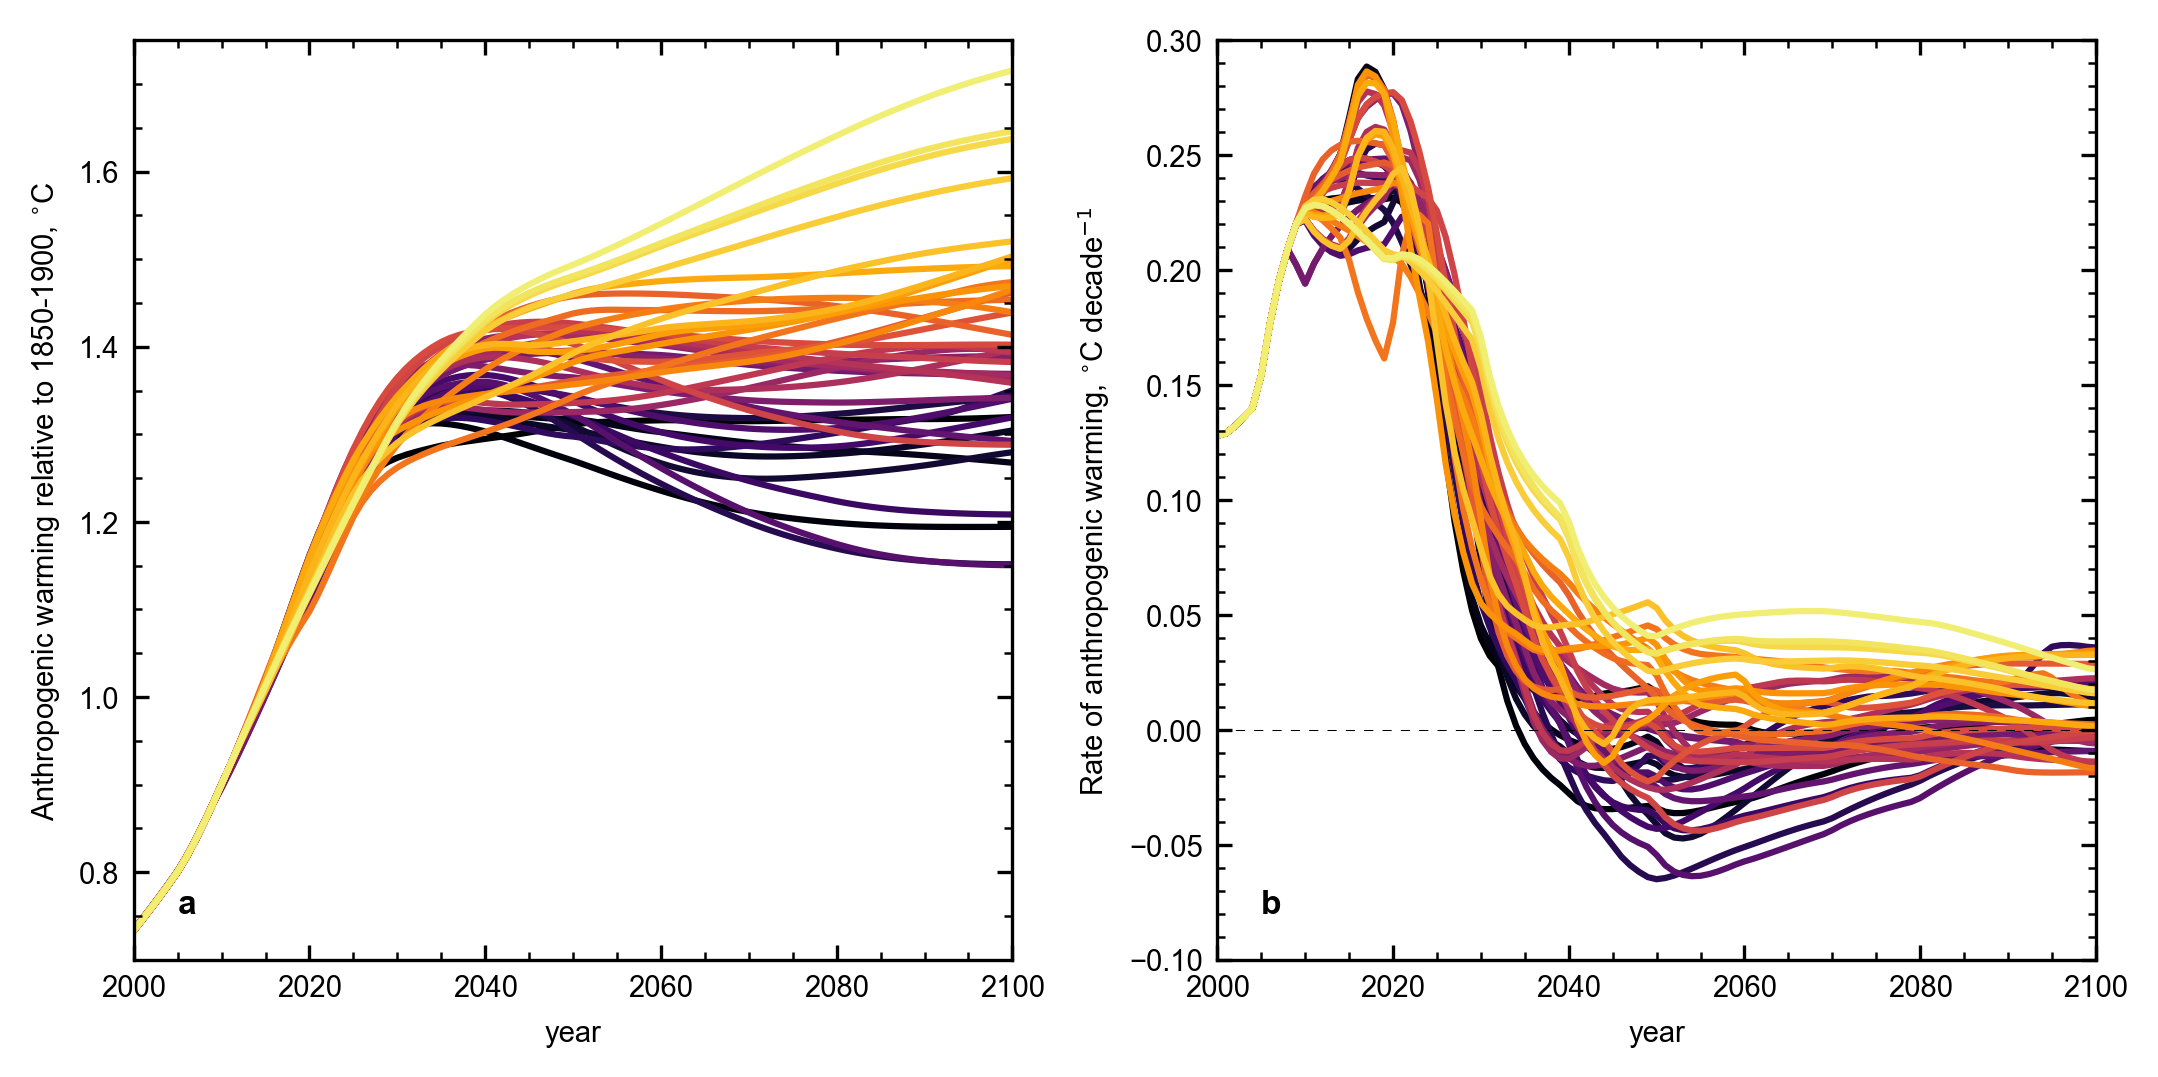

In [12]:
experiment = 'original'
fig,ax=pl.subplots(1,2,figsize=(18.3/2.54,9.15/2.54))
colors = colorspace(len(scenarios.keys()), pl.cm.inferno)
labels_colors = {}
for i, label in enumerate(labels_sorted):
    if i<19:
        labels = [label, None]
    else:
        labels = [None, label]
    ax[0].plot(np.arange(2000,2101), display_temps[experiment][label]['Mean'][235:], label=labels[0], color=colors[i])
    ax[1].plot(np.arange(2000,2101), 10.0*np.gradient(display_temps[experiment][label]['Mean'][235:]), label=labels[1], color=colors[i])
    labels_colors[label] = colors[i]
ax[0].set_ylabel('Anthropogenic warming relative to 1850-1900, $^{\circ}$C')
ax[1].set_ylabel('Rate of anthropogenic warming, $^{\circ}$C decade$^{-1}$')
ax[0].set_xlabel('year')
ax[1].set_xlabel('year')
ax[1].axhline(0, color='k', ls=':', lw=0.25)
ax[0].text(0.05,0.05,'a', weight='bold', size=8, transform=ax[0].transAxes);
ax[1].text(0.05,0.05,'b', weight='bold', size=8, transform=ax[1].transAxes);

ax[0].set_xlim(2000,2100);
ax[0].set_ylim(0.7,1.75);
ax[1].set_xlim(2000,2100);
ax[1].set_ylim(-0.10,0.3);

pl.tight_layout()
pl.savefig('figures/fig2.png')
pl.savefig('figures/fig2.pdf')

## Plot supplementary figure 7

This is in response to a reviewer comment about temperature and effective radiative forcing changes from present-day.

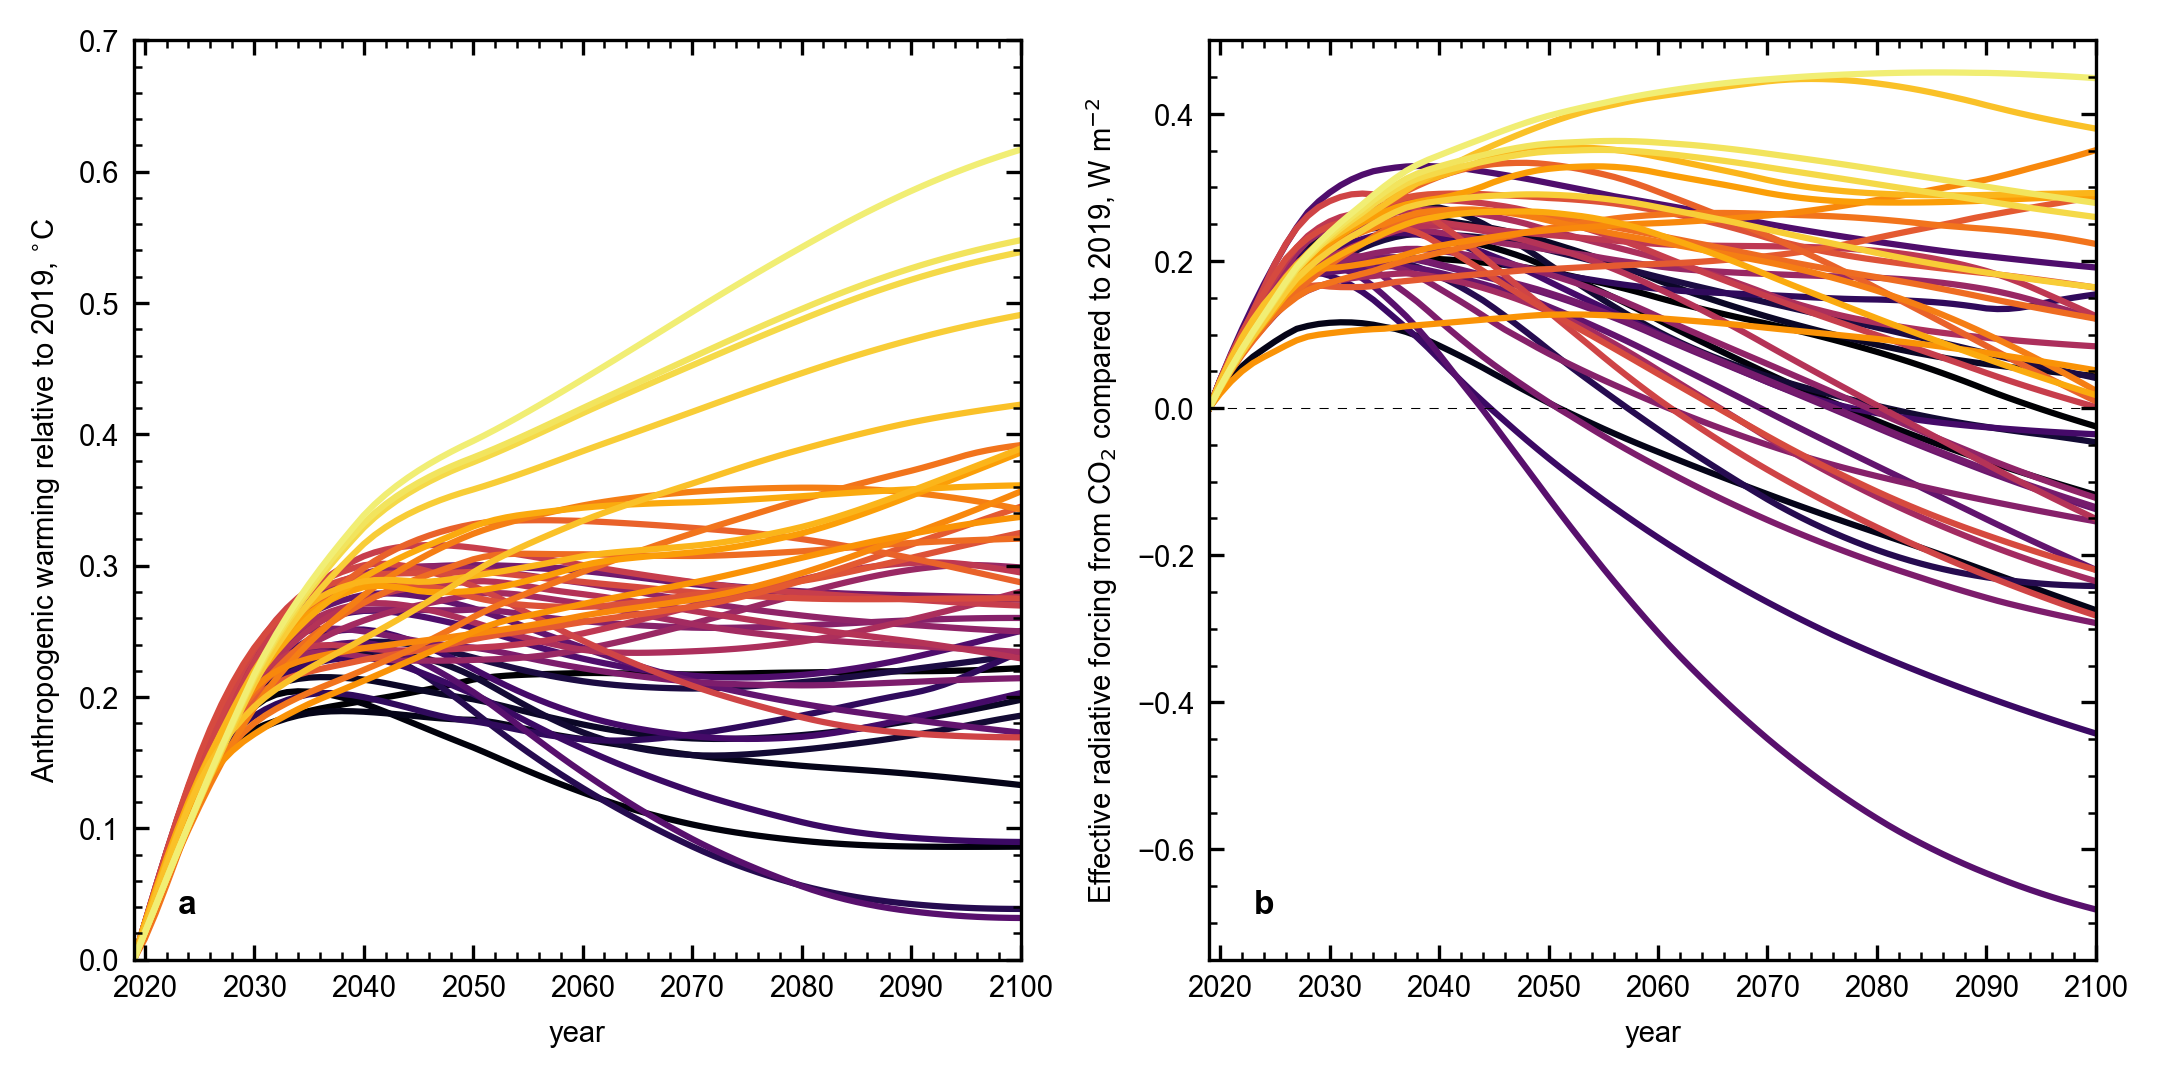

In [13]:
experiment = 'original'
fig,ax=pl.subplots(1,2,figsize=(18.3/2.54,9.15/2.54))
colors = colorspace(len(scenarios.keys()), pl.cm.inferno)
labels_colors = {}
for i, label in enumerate(labels_sorted):
    ax[0].plot(np.arange(2000,2101), display_temps[experiment][label]['Mean'][235:]-display_temps[experiment][label]['Mean'][254], label=labels[0], color=colors[i])
    ax[1].plot(np.arange(2000,2101), scenarios[label]['ERF']['CO2'][235:]-scenarios[label]['ERF']['CO2'][254], label=labels[1], color=colors[i])
    labels_colors[label] = colors[i]
ax[0].set_ylabel('Anthropogenic warming relative to 2019, $^{\circ}$C')
ax[1].set_ylabel('Effective radiative forcing from CO$_2$ compared to 2019, W m$^{-2}$')
ax[0].set_xlabel('year')
ax[1].set_xlabel('year')
ax[1].axhline(0, color='k', ls=':', lw=0.25)
ax[0].text(0.05,0.05,'a', weight='bold', size=8, transform=ax[0].transAxes);
ax[1].text(0.05,0.05,'b', weight='bold', size=8, transform=ax[1].transAxes);

ax[0].set_xlim(2019,2100);
ax[0].set_ylim(0.,0.7);
ax[1].set_xlim(2019,2100);
ax[1].set_ylim(-0.75,0.5);

pl.tight_layout()
pl.savefig('figures/figS7.png')
pl.savefig('figures/figS7.pdf')

## Plot figure 1

Even though the emissions scenarios logically come first, we need to calculate the temperatures to define the colour scheme used throughout the paper.

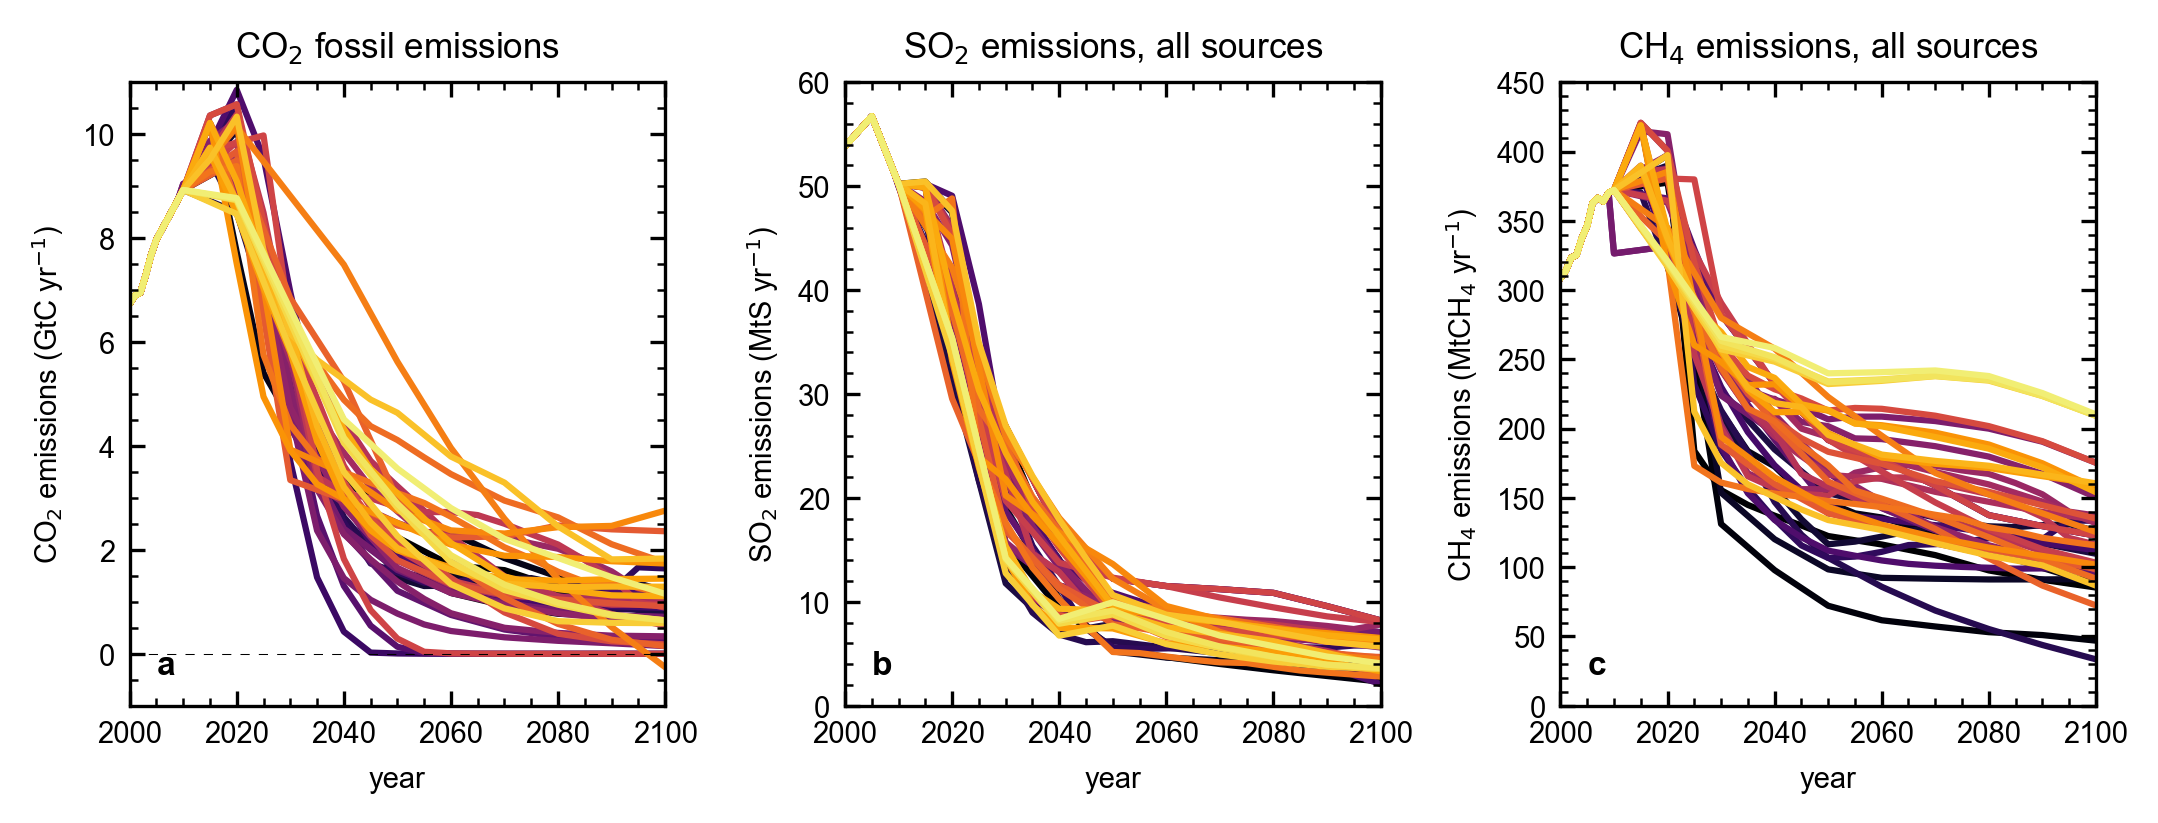

In [14]:
fig = pl.figure(figsize=(18.3/2.54,7/2.54))
gs = gridspec.GridSpec(1, 3)
ax0 = pl.subplot(gs[0, 0])
ax1 = pl.subplot(gs[0, 1])
ax2 = pl.subplot(gs[0, 2])

for i, label in enumerate(labels_sorted):
    ax0.plot(np.arange(2000,2101), scenarios[label]['Emissions'][235:336,1]+scenarios[label]['BECCS'][235:336]+scenarios[label]['Enhanced Weathering'][235:336], label=label, color=labels_colors[label])
    ax1.plot(np.arange(2000,2101), scenarios[label]['Emissions'][235:336,5], label=label, color=labels_colors[label])
    ax2.plot(np.arange(2000,2101), scenarios[label]['Emissions'][235:336,3], label=label, color=labels_colors[label])

ax0.set_ylabel('CO$_2$ emissions (GtC yr$^{-1}$)');
ax1.set_ylabel('SO$_2$ emissions (MtS yr$^{-1}$)');
ax2.set_ylabel('CH$_4$ emissions (MtCH$_4$ yr$^{-1}$)');
ax0.set_xlabel('year');
ax1.set_xlabel('year');
ax2.set_xlabel('year');
ax0.set_title('CO$_2$ fossil emissions');
ax1.set_title('SO$_2$ emissions, all sources');
ax2.set_title('CH$_4$ emissions, all sources')

ax0.axhline(0, color='k', ls=':', lw=0.25)
ax0.set_xlim(2000,2100);
ax1.set_xlim(2000,2100);
ax2.set_xlim(2000,2100);
ax0.set_ylim(-1,11);
ax1.set_ylim(0,60);
ax2.set_ylim(0,450);
ax0.text(0.05,0.05,'a', weight='bold', size=8, transform=ax0.transAxes);
ax1.text(0.05,0.05,'b', weight='bold', size=8, transform=ax1.transAxes);
ax2.text(0.05,0.05,'c', weight='bold', size=8, transform=ax2.transAxes);
pl.tight_layout()

pl.savefig('figures/fig1.png')
pl.savefig('figures/fig1.pdf')

## Plot supplementary figure 9

Now that we have our colour scheme, we can plot the global legend which is ordered dark to light in ascending peak global mean temperature. Owing to the slight differences between the original SCEN files and the publicly available data, this may not be in exactly the same order as in the published paper.

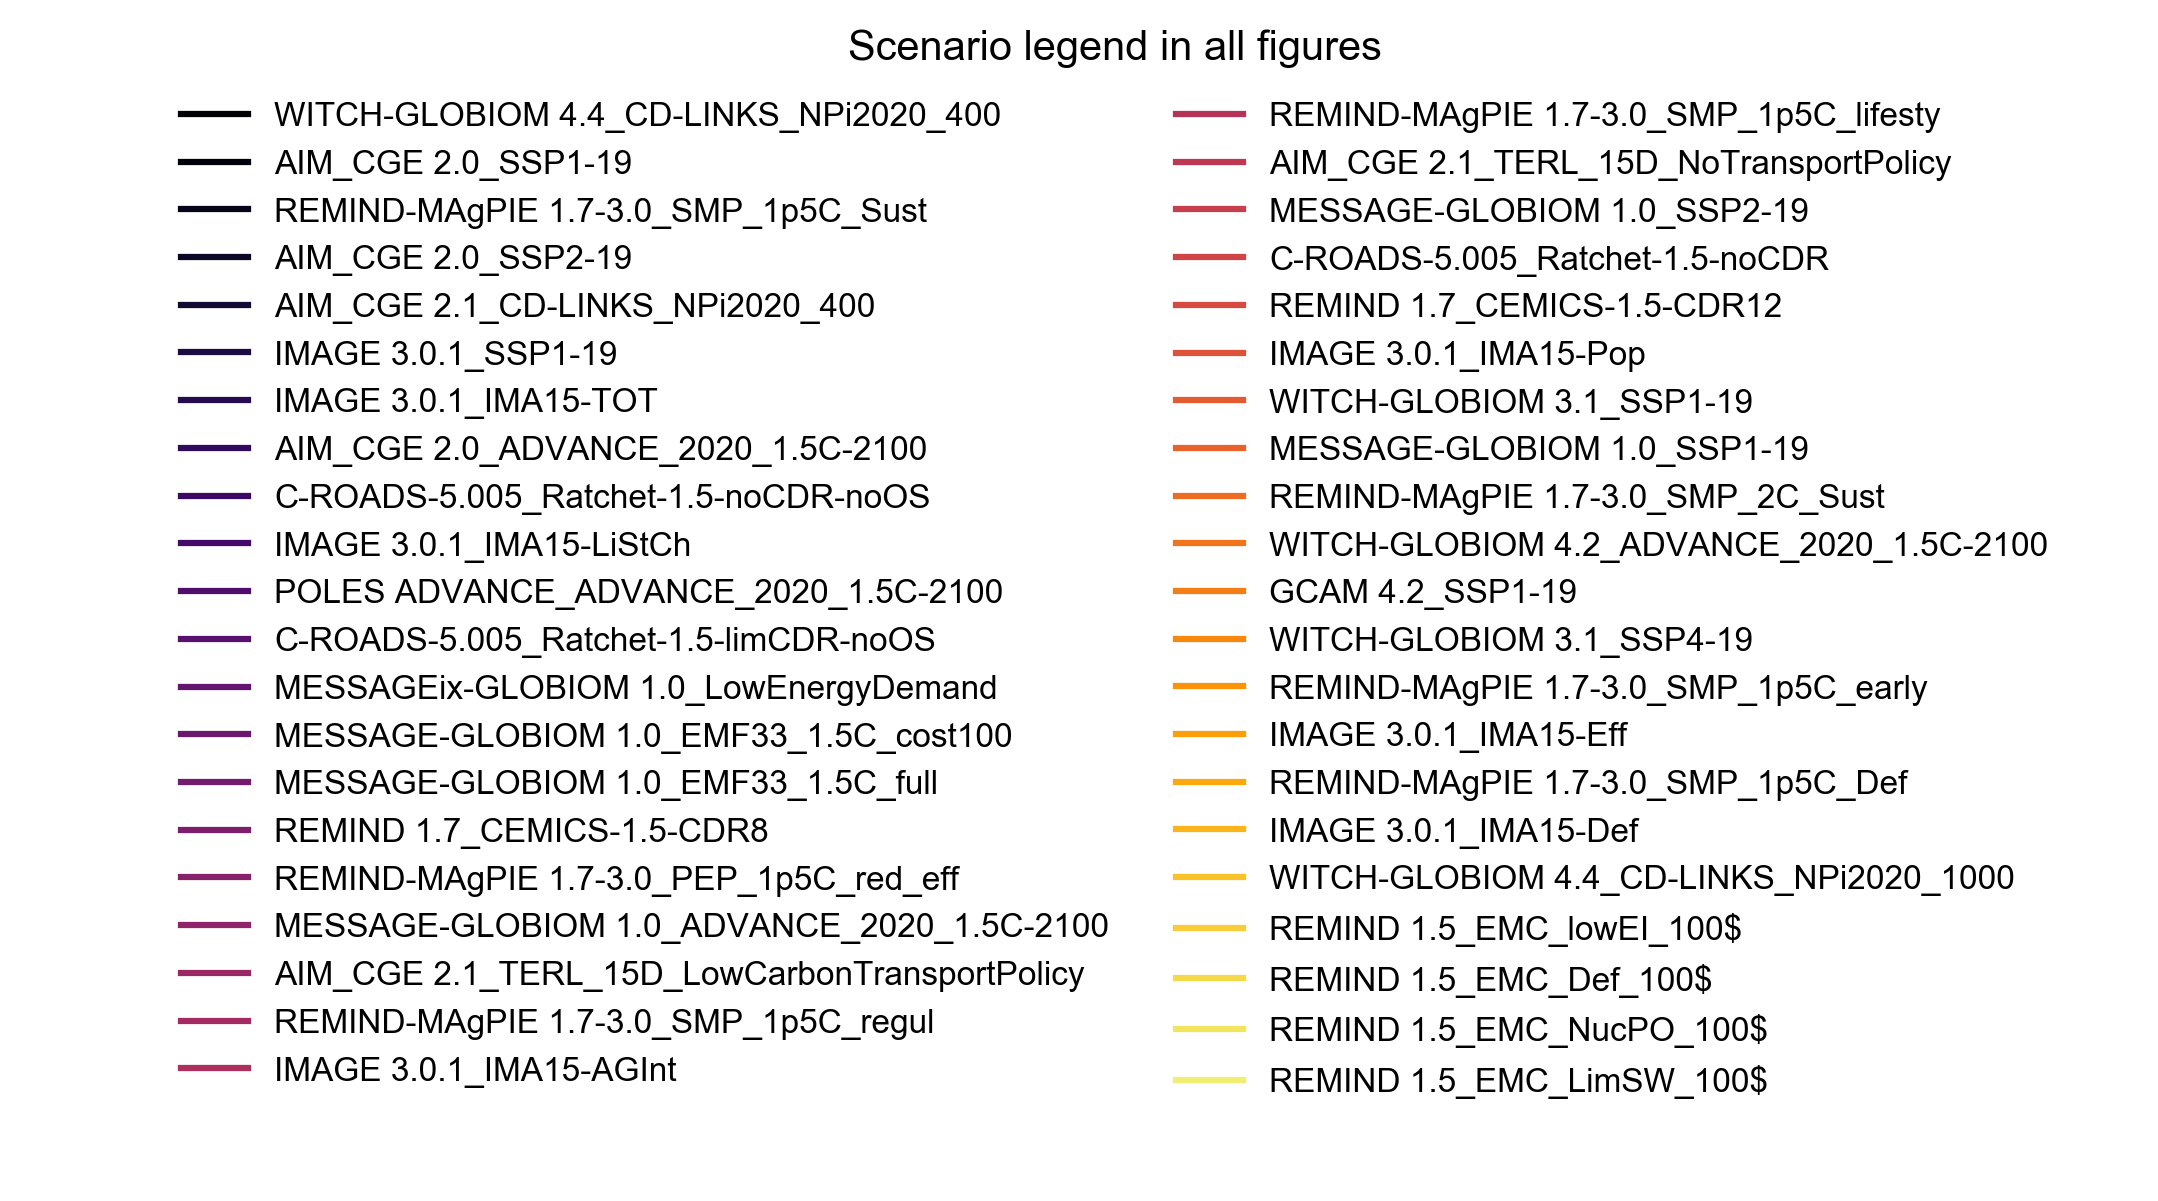

In [15]:
fig, ax = pl.subplots(figsize=(18.3/2.54,10.2/2.54))
for i, label in enumerate(labels_sorted):
    ax.plot((0,0), (1,1), label=label, color=labels_colors[label])
ax.legend(fontsize=8, ncol=2, loc='lower center', frameon=False)
ax.set_title('Scenario legend in all figures', fontsize=10);
ax.axis('off');
fig.tight_layout()
pl.savefig('figures/figS9.png')
pl.savefig('figures/figS9.pdf')

## Plot supplementary Figure 1: fossil fraction of SLCFs

Provides a plot for 7 short-lived climate forcers (SLCFs) for the 17 scenarios in each scenario that give them.

### Try and isolate the fossil OC, BC, CO, CH4, SOx, NOx and VOC components from the scenarios

Two problems here:
1. a problem is not all scenarios have this level of detail, so take a group average based only on those that do.
2. in some scenarios, the sum of energy + AFOLU + other does not equal the total; so we should only base the analysis on the models in which this holds.

Generally, "other" is quite a small proportion of the total, and is likely to vary between scenarios/modelling groups in the way it is accounted for. So, we just look at AFOLU as a proportion of total, and bin everything that is not AFOLU into fossil (with the exception of methane, in which we start with energy sector emissions and assume everything else is non-fossil). The plots below show the fossil fraction from the 17 out of 42 scenarios that include this breakdown. The thick black line is the average, which we apply as the fossil fraction to all scenarios.

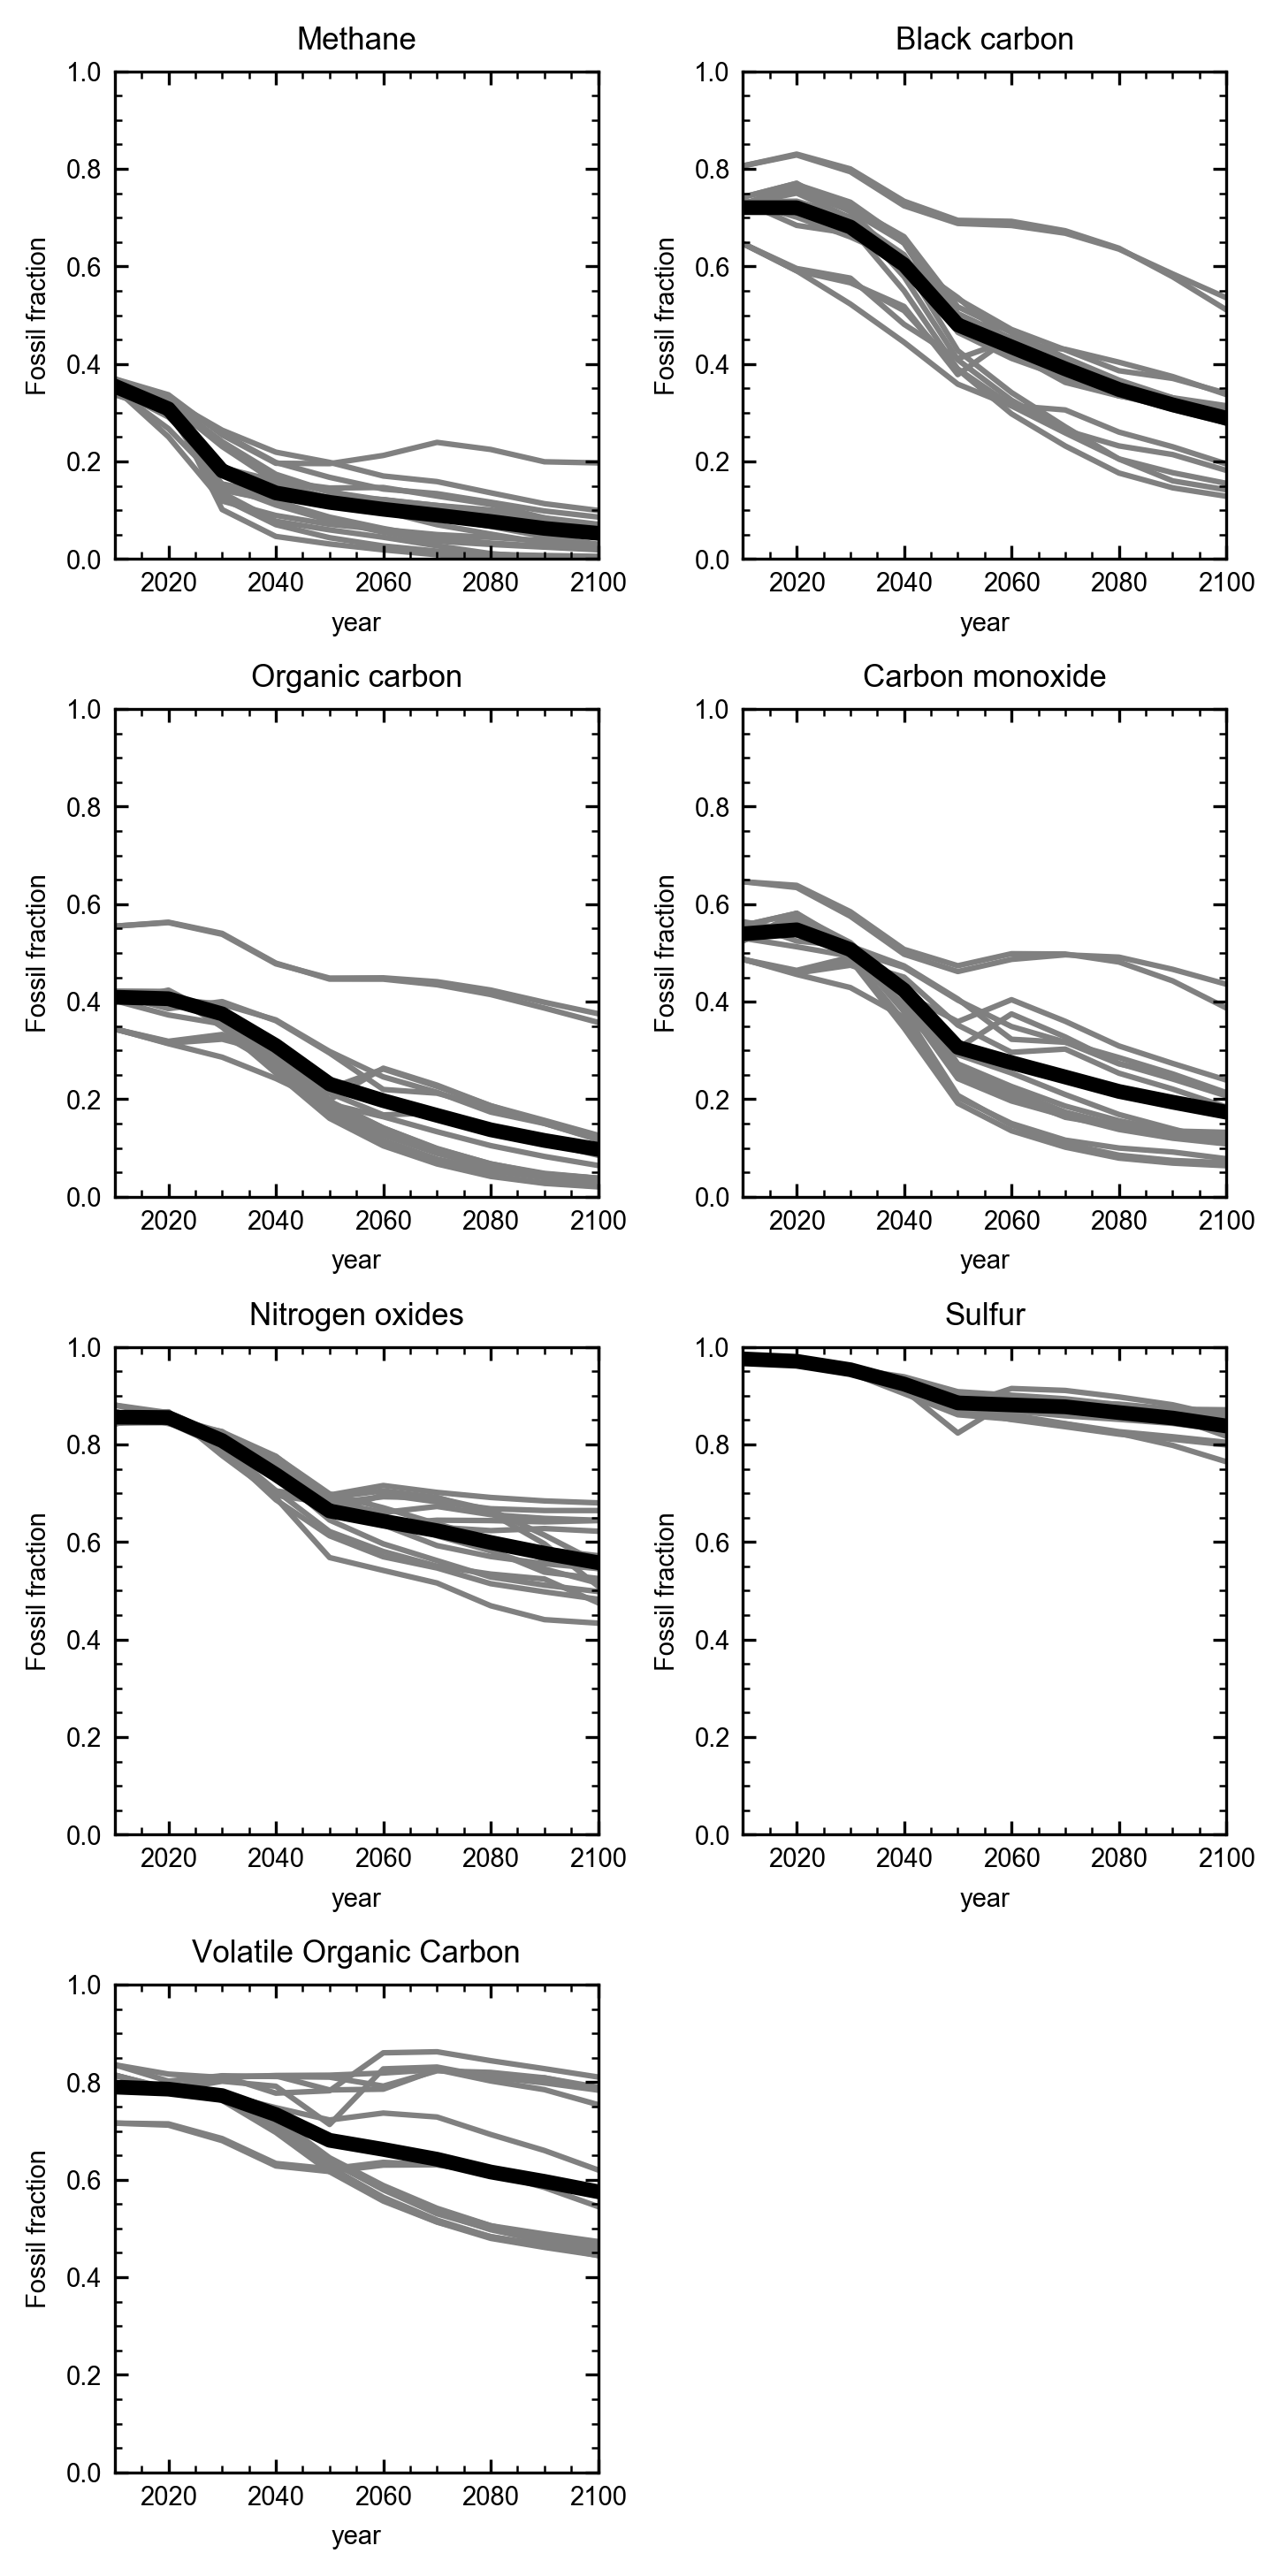

In [16]:
scenbd = pd.read_csv('input_data/emissions/non_fossil.csv')

variables = ['Emissions|CH4|Energy', 'Emissions|CH4', 'Emissions|BC|AFOLU', 'Emissions|BC', 'Emissions|OC|AFOLU',
             'Emissions|OC', 'Emissions|CO|AFOLU', 'Emissions|CO', 'Emissions|NOx|AFOLU', 'Emissions|NOx',
             'Emissions|Sulfur|AFOLU', 'Emissions|Sulfur', 'Emissions|VOC|AFOLU', 'Emissions|VOC']

ratios = ['CH4', 'BC', 'OC', 'CO', 'NOx', 'Sulfur', 'VOC']
ratios_long = ['Methane', 'Black carbon', 'Organic carbon', 'Carbon monoxide', 'Nitrogen oxides', 'Sulfur', 'Volatile Organic Carbon']

indices = {}
labels = {}
fossil_fraction = {}

for var in variables:
# Find all scenarios in which AFOLU/total ratio is defined for every species of interest
    indices[var] = scenbd.loc[scenbd.Variable == var].index
    labels[var] = []
    for i in indices[var]:
        labels[var].append('%s::%s' % (scenbd.iloc[i].Model, scenbd.iloc[i].Scenario))
    labels[var] = set(labels[var])

    
def get_intersection(s):
    """ return an intersection from a set of lists """  
    i = set(s[0])
    for x in s[1:]:
        i = i & set(x)
    return i        

common = get_intersection([labels[var] for var in labels.keys()])

for ratio in ratios:
    fossil_fraction[ratio] = np.zeros((10, len(common)))
    
years = [str(y) for y in range(2010, 2110, 10)]

for i, label in enumerate(common):
    ms = label.split('::')
    model = ms[0]
    scenario = ms[1]
    # pair these off
    ratio = 'CH4'
    energy = scenbd.loc[(scenbd.Variable == 'Emissions|%s|Energy' % ratio) & (scenbd.Model == model) &
                        (scenbd.Scenario == scenario), years].values[:]
    total =  scenbd.loc[(scenbd.Variable == 'Emissions|%s' % ratio) & (scenbd.Model == model) &
                        (scenbd.Scenario == scenario), years].values[:]
    fossil_fraction[ratio][:, i] = energy/total
    for ratio in ratios[1:]:
        afolu =  scenbd.loc[(scenbd.Variable == 'Emissions|%s|AFOLU' % ratio) & (scenbd.Model == model) &
                            (scenbd.Scenario == scenario), years].values[:]
        total =  scenbd.loc[(scenbd.Variable == 'Emissions|%s' % ratio) & (scenbd.Model == model) &
                            (scenbd.Scenario == scenario), years].values[:]    
        fossil_fraction[ratio][:, i] = 1. - afolu/total 

mean_fossil_fraction = {}

fig,ax=pl.subplots(4,2,figsize=(12.3/2.54,24.7/2.54))
for i, ratio in enumerate(ratios):
    mff = np.mean(fossil_fraction[ratio], axis=1)
    f = interp1d(np.arange(2010,2110,10), mff)
    mean_fossil_fraction[ratio] = f(np.arange(2010,2101))
    ax[i//2, i%2].plot(np.arange(2010,2110,10), fossil_fraction[ratio], color='gray')
    ax[i//2, i%2].plot(np.arange(2010,2101), mean_fossil_fraction[ratio], color='k', lw=4)
    ax[i//2, i%2].set_title(ratios_long[i])
    ax[i//2, i%2].set_xlim(2010,2100)
    ax[i//2, i%2].set_ylim(0,1)
    ax[i//2, i%2].set_xlabel('year')
    ax[i//2, i%2].set_ylabel('Fossil fraction')

pl.tight_layout()   
ax[3,1].set_visible(False)

pl.savefig('figures/figS1.png')
pl.savefig('figures/figS1.pdf')

## Re-run the same scenarios but now setting different categories of emissions to 2019 levels

Now we get to the crux of the investigation - how temperature profiles vary compared to the original pathways by setting a particular categories of emissions to constant 2019 levels. We use the same probabilistic setups as before, and look at the spread in ensemble differences.

**This section takes ~4 hours to run on Hopper**

In [17]:
# Comment out this block if you don't want to run experiments
experiments = ['constant_co2', 'constant_so2', 'constant_ch4', 'zero_so2', 
               'constant_co2so2', 'constant_all', 'constant_ch4AR5', 'constant_allAR5']
avi = rcp3pd.aviNOx_frac
ch4 = rcp3pd.fossilCH4_frac
ch4[245:336] = mean_fossil_fraction['CH4']
ch4[336:] = ch4[335]
nat = natural.Emissions.emissions
efficacy = np.ones(13); efficacy[9] = 3.0
tcr_dbl = np.log(2.0)/np.log(1.01)

for experiment in tqdm_notebook(experiments):
    mkdir_p('output_data/%s' % experiment)
    for i, label in enumerate(tqdm_notebook(scenarios.keys(), leave=False)):
        naccept = np.sum(accept[label])
        E       = np.copy(scenarios[label]['Emissions'][:nt,:])
        E[:, 1] = E[:, 1] + scenarios[label]['BECCS'] + scenarios[label]['Enhanced Weathering']
        C_CO2   = np.zeros((nt, naccept))
        F       = np.zeros((nt, 13, naccept))
        T       = np.zeros((nt, naccept))
        if experiment=='constant_co2':
            E[254:,1] = E[253,1]
        elif experiment=='constant_so2':
            E[254:,5] = E[253,5] * mean_fossil_fraction['Sulfur'][8] + E[254:,5] * (1. - mean_fossil_fraction['Sulfur'][9:])
        elif experiment.startswith('constant_ch4'):
            E[254:,3] = E[253,3] * mean_fossil_fraction['CH4'][8] + E[254:,3] * (1. - mean_fossil_fraction['CH4'][9:])
        elif experiment=='zero_so2':
            E[254:,5] = (1. - mean_fossil_fraction['Sulfur'][9:]) * E[254:,5]
        elif experiment=='constant_co2so2':
            E[254:,1] = E[253,1]
            E[254:,5] = E[253,5] * mean_fossil_fraction['Sulfur'][8] + E[254:,5] * (1. - mean_fossil_fraction['Sulfur'][9:])
        elif experiment.startswith('constant_all'):
            E[254:,1] = E[253,1]
            E[254:,3] = E[253,3] * mean_fossil_fraction['CH4'][8] + E[254:,3] * (1. - mean_fossil_fraction['CH4'][9:])
            E[254:,5] = E[253,5] * mean_fossil_fraction['Sulfur'][8] + E[254:,5] * (1. - mean_fossil_fraction['Sulfur'][9:])
            E[254:,6] = E[253,6] * mean_fossil_fraction['CO'][8] + E[254:,6] * (1. - mean_fossil_fraction['CO'][9:])
            E[254:,7] = E[253,7] * mean_fossil_fraction['NOx'][8] + E[254:,7] * (1. - mean_fossil_fraction['NOx'][9:])
            E[254:,8] = E[253,8] * mean_fossil_fraction['VOC'][8] + E[254:,8] * (1. - mean_fossil_fraction['VOC'][9:])
            E[254:,9] = E[253,9] * mean_fossil_fraction['BC'][8] + E[254:,9] * (1. - mean_fossil_fraction['BC'][9:])
            E[254:,10] = E[253,10] * mean_fossil_fraction['OC'][8] + E[254:,10] * (1. - mean_fossil_fraction['OC'][9:])
            
        if experiment.endswith('AR5'):
            ghg_forcing='Myhre'
        else:
            ghg_forcing='Etminan'
        scenarios[label]['Temperature'] = {}
        Fscale = np.ones(13)
        iaccept = 0
        for ens in tqdm_notebook(range(n), leave=False):
            if accept[label][ens] == False:
                continue
            Fscale[1:12] = scale[ens,1:12]
            thisC, thisF, thisT = fair_scm(emissions=E,
                ghg_forcing    = ghg_forcing,
                tcrecs         = ecstcr[ens,::-1],
                F_volcanic     = 0.0,
                F_solar        = 0.0,
                natural        = nat[:nt,:],
                r0             = 35.0*rscale[ens,0],
                rt             = 4.165*rscale[ens,1],
                rc             = 0.019*rscale[ens,2],
                d              = [d2[ens], d1[ens]],
                F2x            = 3.71 * scale[ens,0],
                scale          = Fscale,
                tcr_dbl        = tcr_dbl,
                aviNOx_frac    = avi[:nt],
                fossilCH4_frac = ch4[:nt],
                efficacy       = efficacy,
                scaleHistoricalAR5=True,
            )
            C_CO2[:, iaccept] = thisC[:, 0]
            F[:,:,iaccept]    = thisF
            T[:,iaccept]      = thisT

            iaccept+=1

        ncout = Dataset('output_data/%s/%s.nc' % (experiment,label), 'w')
        timdim = ncout.createDimension('time', None)
        rundim = ncout.createDimension('run',naccept)
        agtdim = ncout.createDimension('agent', 13)
        timvar = ncout.createVariable('time','i4',('time',))
        runvar = ncout.createVariable('run','i4',('run',))
        agtvar = ncout.createVariable('agent', 'i2', ('agent',))
        frcvar = ncout.createVariable('forc','f4',('time','agent','run'))
        tmpvar = ncout.createVariable('temp','f4',('time','run'))
        cncvar = ncout.createVariable('co2conc', 'f4', ('time','run',))
        timvar[:] = np.arange(1765,2101)
        frcvar[:] = F
        runvar[:] = np.where(accept[label]==True)
        agtvar[:] = np.arange(13)
        tmpvar[:] = T
        cncvar[:] = C_CO2
        ncout.close()

## Plot figure 3

This shows the comparison of each constant-emissions pathway with the original scenario, and represents the additional near-term warming due to the phasing out of a particular pollutant or combination of pollutants.

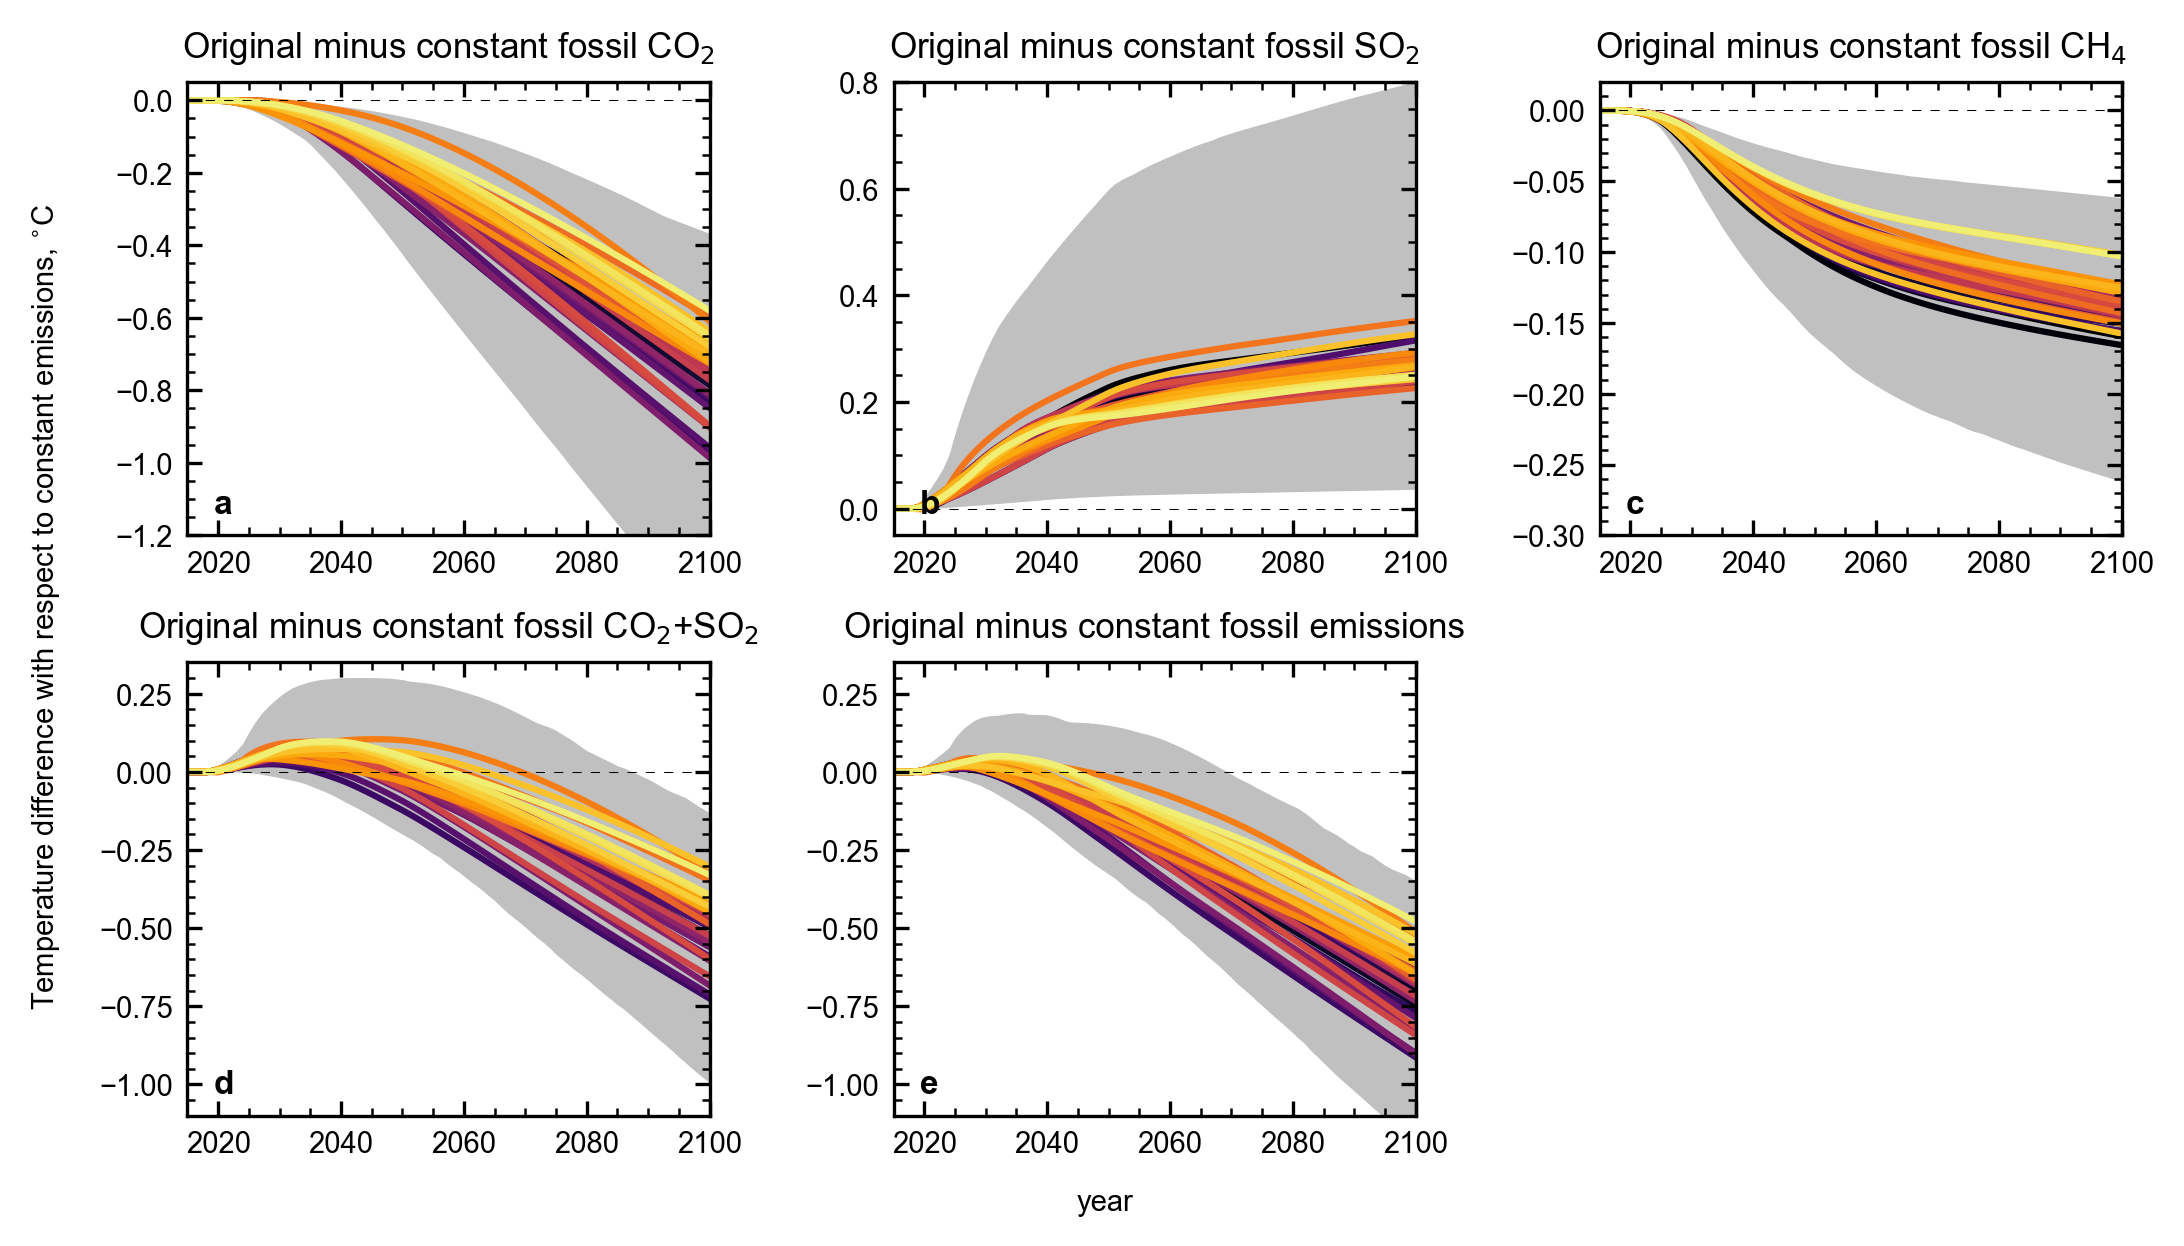

In [18]:
experiments = ['constant_co2', 'constant_so2', 'constant_ch4', 'zero_so2',
               'constant_co2so2', 'constant_all']
fig = pl.figure(figsize=(18.3/2.54,10.3/2.54))
gs = gridspec.GridSpec(2, 3)
ax = [''] * 5
ax[0] = pl.subplot(gs[0, 0])
ax[1] = pl.subplot(gs[0, 1])
ax[2] = pl.subplot(gs[0, 2])
ax[3] = pl.subplot(gs[1, 0])
ax[4] = pl.subplot(gs[1, 1])

for j, experiment in enumerate(experiments):
    display_temps[experiment] = {}
    for i, label in enumerate(scenarios.keys()):
        display_temps[experiment][label] = {}
        nc = Dataset('output_data/%s/%s.nc' % (experiment,label))
        T2 = nc.variables['temp'][:] - np.mean(nc.variables['temp'][85:136,:], axis=0)
        nc.close()
        nc = Dataset('output_data/original/%s.nc' % (label))
        T1 = nc.variables['temp'][:] - np.mean(nc.variables['temp'][85:136,:], axis=0)
        nc.close()
        display_temps[experiment][label]['Mean'] = np.mean(T2-T1, axis=1)
        (
            display_temps[experiment][label]['P5'],
            display_temps[experiment][label]['Median'],
            display_temps[experiment][label]['P66'],
            display_temps[experiment][label]['P90'],
            display_temps[experiment][label]['P95'],
        ) = np.percentile(T2-T1, (5,50,66,90,95), axis=1)

max_95_3d = np.zeros(len(labels_sorted))
max_mean_3d = np.zeros(len(labels_sorted))
max_95_3e = np.zeros(len(labels_sorted))
max_mean_3e = np.zeros(len(labels_sorted))
max_95_3dnew = np.zeros(len(labels_sorted))
max_mean_3dnew = np.zeros(len(labels_sorted))
max_95_3enew = np.zeros(len(labels_sorted))
max_mean_3enew = np.zeros(len(labels_sorted))

p95_3a = np.zeros((101, len(labels_sorted)))
p95_3b = np.zeros((101, len(labels_sorted)))
p95_3c = np.zeros((101, len(labels_sorted)))
p95_3d = np.zeros((101, len(labels_sorted)))
p95_3e = np.zeros((101, len(labels_sorted)))
p05_3a = np.zeros((101, len(labels_sorted)))
p05_3b = np.zeros((101, len(labels_sorted)))
p05_3c = np.zeros((101, len(labels_sorted)))
p05_3d = np.zeros((101, len(labels_sorted)))
p05_3e = np.zeros((101, len(labels_sorted)))

for i, label in enumerate(labels_sorted):
    delta_co2 = -display_temps['constant_co2'][label]['Mean'][235:]
    delta_so2 = -display_temps['constant_so2'][label]['Mean'][235:]
    delta_ch4 = -display_temps['constant_ch4'][label]['Mean'][235:]
    delta_cds = -display_temps['constant_co2so2'][label]['Mean'][235:]
    delta_all = -display_temps['constant_all'][label]['Mean'][235:]
    
    delta_co2_05 = -display_temps['constant_co2'][label]['P5'][235:]
    delta_so2_05 = -display_temps['constant_so2'][label]['P5'][235:]
    delta_ch4_05 = -display_temps['constant_ch4'][label]['P5'][235:]
    delta_cds_05 = -display_temps['constant_co2so2'][label]['P5'][235:]
    delta_all_05 = -display_temps['constant_all'][label]['P5'][235:]

    delta_co2_95 = -display_temps['constant_co2'][label]['P95'][235:]
    delta_so2_95 = -display_temps['constant_so2'][label]['P95'][235:]
    delta_ch4_95 = -display_temps['constant_ch4'][label]['P95'][235:]
    delta_cds_95 = -display_temps['constant_co2so2'][label]['P95'][235:]
    delta_all_95 = -display_temps['constant_all'][label]['P95'][235:]
    
    p95_3a[:,i] = delta_co2_95
    p95_3b[:,i] = delta_so2_95
    p95_3c[:,i] = delta_ch4_95
    p95_3d[:,i] = delta_cds_95
    p95_3e[:,i] = delta_all_95
    p05_3a[:,i] = delta_co2_05
    p05_3b[:,i] = delta_so2_05
    p05_3c[:,i] = delta_ch4_05
    p05_3d[:,i] = delta_cds_05
    p05_3e[:,i] = delta_all_05
    
    ax[0].plot(np.arange(2000,2101), delta_co2, label=label, color=labels_colors[label])
    ax[1].plot(np.arange(2000,2101), delta_so2, label=label, color=labels_colors[label])
    ax[2].plot(np.arange(2000,2101), delta_ch4, label=label, color=labels_colors[label])
    ax[3].plot(np.arange(2000,2101), delta_cds, label=label, color=labels_colors[label])
    ax[4].plot(np.arange(2000,2101), delta_all, label=label, color=labels_colors[label])
    max_mean_3dnew[i] = np.max(delta_cds)
    max_95_3dnew[i] = np.max(delta_cds_95)
    max_mean_3enew[i] = np.max(delta_all)
    max_95_3enew[i] = np.max(delta_all_95)
    
# get range of 95th percentile temperatures
top3a = reduce(np.maximum, (np.max(p05_3a, axis=1), np.max(p95_3a, axis=1), np.min(p05_3a, axis=1), np.min(p95_3a, axis=1)))
bot3a = reduce(np.minimum, (np.min(p05_3a, axis=1), np.min(p95_3a, axis=1), np.max(p05_3a, axis=1), np.max(p95_3a, axis=1)))
top3b = reduce(np.maximum, (np.max(p05_3b, axis=1), np.max(p95_3b, axis=1), np.min(p05_3b, axis=1), np.min(p95_3b, axis=1)))
bot3b = reduce(np.minimum, (np.min(p05_3b, axis=1), np.min(p95_3b, axis=1), np.max(p05_3b, axis=1), np.max(p95_3b, axis=1)))
top3c = reduce(np.maximum, (np.max(p05_3c, axis=1), np.max(p95_3c, axis=1), np.min(p05_3c, axis=1), np.min(p95_3c, axis=1)))
bot3c = reduce(np.minimum, (np.min(p05_3c, axis=1), np.min(p95_3c, axis=1), np.max(p05_3c, axis=1), np.max(p95_3c, axis=1)))
top3d = reduce(np.maximum, (np.max(p05_3d, axis=1), np.max(p95_3d, axis=1), np.min(p05_3d, axis=1), np.min(p95_3d, axis=1)))
bot3d = reduce(np.minimum, (np.min(p05_3d, axis=1), np.min(p95_3d, axis=1), np.max(p05_3d, axis=1), np.max(p95_3d, axis=1)))
top3e = reduce(np.maximum, (np.max(p05_3e, axis=1), np.max(p95_3e, axis=1), np.min(p05_3e, axis=1), np.min(p95_3e, axis=1)))
bot3e = reduce(np.minimum, (np.min(p05_3e, axis=1), np.min(p95_3e, axis=1), np.max(p05_3e, axis=1), np.max(p95_3e, axis=1)))

ax[0].fill_between(np.arange(2000,2101), bot3a, top3a, color='#c0c0c0', linewidth=0)
ax[1].fill_between(np.arange(2000,2101), bot3b, top3b, color='#c0c0c0', linewidth=0)
ax[2].fill_between(np.arange(2000,2101), bot3c, top3c, color='#c0c0c0', linewidth=0)
ax[3].fill_between(np.arange(2000,2101), bot3d, top3d, color='#c0c0c0', linewidth=0)
ax[4].fill_between(np.arange(2000,2101), bot3e, top3e, color='#c0c0c0', linewidth=0)
    
ax[0].set_title('Original minus constant fossil CO$_2$')
ax[1].set_title('Original minus constant fossil SO$_2$')
ax[2].set_title('Original minus constant fossil CH$_4$')
ax[3].set_title('Original minus constant fossil CO$_2$+SO$_2$')
ax[4].set_title('Original minus constant fossil emissions')

ax[0].set_xlim(2015,2100);
ax[1].set_xlim(2015,2100);
ax[2].set_xlim(2015,2100);
ax[3].set_xlim(2015,2100);
ax[4].set_xlim(2015,2100);

ax[0].set_ylim(-1.2,0.05);
ax[1].set_ylim(-0.05,0.8);
ax[2].set_ylim(-0.3,0.02);
ax[3].set_ylim(-1.1,0.35);
ax[4].set_ylim(-1.1,0.35);

ax[0].axhline(0, color='k', ls=':', lw=0.25)
ax[1].axhline(0, color='k', ls=':', lw=0.25)
ax[2].axhline(0, color='k', ls=':', lw=0.25)
ax[3].axhline(0, color='k', ls=':', lw=0.25)
ax[4].axhline(0, color='k', ls=':', lw=0.25)

ax[3].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[4].yaxis.set_minor_locator(MultipleLocator(0.05))

letters = ['a','b','c','d','e']
for i in range(5):
    ax[i].text(0.05,0.05,letters[i], weight='bold', size=8, transform=ax[i].transAxes);

pl.figtext(0.01,0.5,'Temperature difference with respect to constant emissions, $^{\circ}$C',rotation=90,va='center', ha='center');
pl.figtext(0.5,0.01,'year',ha='center',va='center');
fig.tight_layout(rect=[0.02,0.02,1,1])
pl.savefig('figures/fig3.png')
pl.savefig('figures/fig3.pdf')

In [19]:
print "95th percentile 'climate penalty' for phase out of CO2 + SO2:", np.max(top3d)
print "Range of ensemble means: ", np.min(max_mean_3dnew), np.max(max_mean_3dnew)
print "95th percentile of 'climate penalty' for phase out of all fossil emissions:", np.max(top3e)
print "Range of ensemble means: ", np.min(max_mean_3enew), np.max(max_mean_3enew)

95th percentile 'climate penalty' for phase out of CO2 + SO2: 0.301936686039
Range of ensemble means:  0.0243887584656 0.104673199356
95th percentile of 'climate penalty' for phase out of all fossil emissions: 0.189088773727
Range of ensemble means:  0.0102505655959 0.050884027034


## Plot supplementary figure 2

the increase in warming from reducing sulfur emissions instantaneously to zero

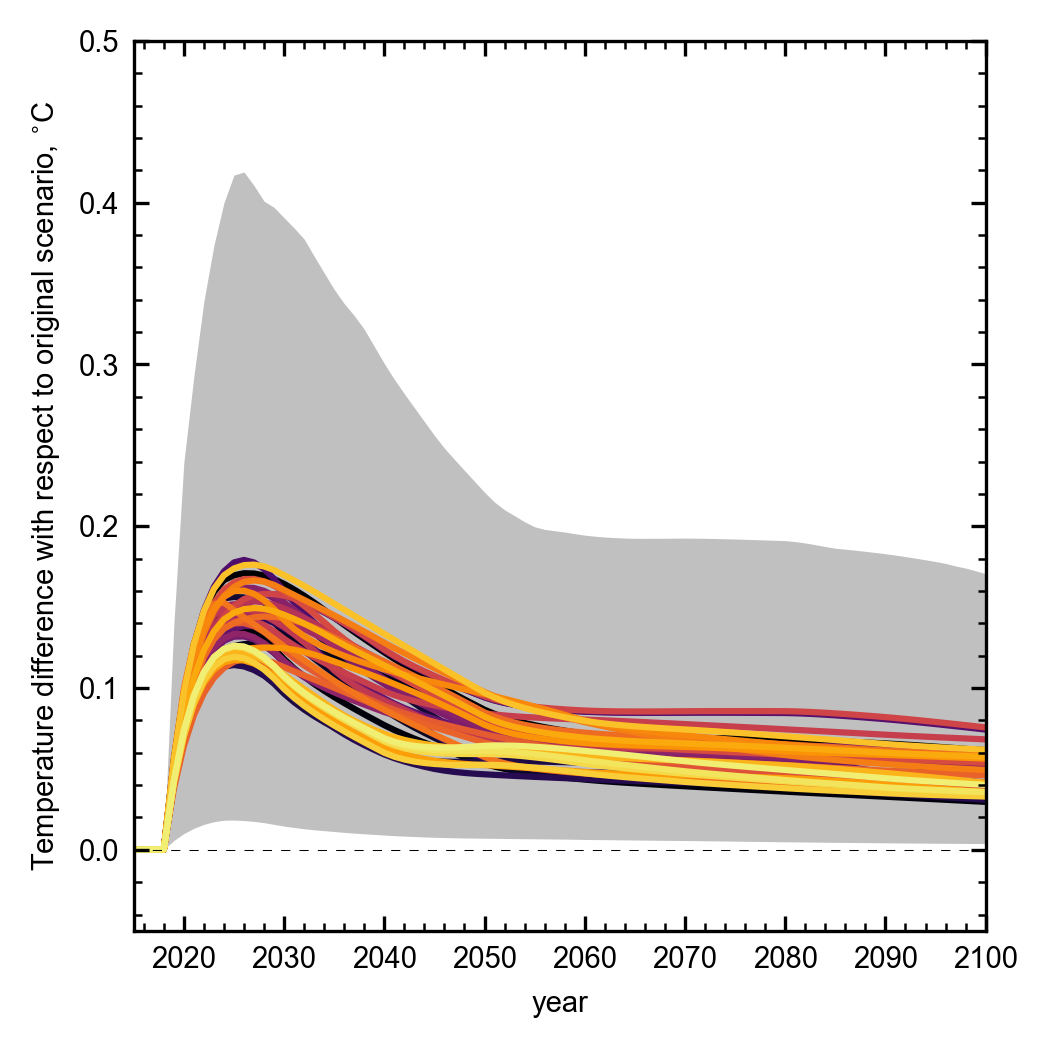

In [20]:
experiments = ['zero_so2']
fig, ax = pl.subplots(figsize=(8.9/2.54,8.9/2.54))

p95_s2 = np.zeros((101, len(labels_sorted)))
p05_s2 = np.zeros((101, len(labels_sorted)))

forcing_delta = {}

for j, experiment in enumerate(experiments):
    display_temps[experiment] = {}
    for i, label in enumerate(scenarios.keys()):
        display_temps[experiment][label] = {}
        nc = Dataset('output_data/%s/%s.nc' % (experiment,label))
        T2 = nc.variables['temp'][:] - np.mean(nc.variables['temp'][85:136,:], axis=0)
        nc.close()
        nc = Dataset('output_data/original/%s.nc' % (label))
        T1 = nc.variables['temp'][:] - np.mean(nc.variables['temp'][85:136,:], axis=0)
        nc.close()
        display_temps[experiment][label]['Mean'] = np.mean(T2-T1, axis=1)
        (
            display_temps[experiment][label]['P5'],
            display_temps[experiment][label]['Median'],
            display_temps[experiment][label]['P66'],
            display_temps[experiment][label]['P90'],
            display_temps[experiment][label]['P95'],
        ) = np.percentile(T2-T1, (5,50,66,90,95), axis=1)

    
for i, label in enumerate(labels_sorted):
    delta_so2 = display_temps['zero_so2'][label]['Mean'][235:]
    delta_so2_05 = display_temps['zero_so2'][label]['P5'][235:]
    delta_so2_95 = display_temps['zero_so2'][label]['P95'][235:]

    #ax.fill_between(np.arange(2000,2101), delta_so2_05, delta_so2_95, color=colors[i], alpha=0.01)
    ax.plot(np.arange(2000,2101), delta_so2, label=label, color=labels_colors[label])

    p95_s2[:,i] = delta_so2_95
    p05_s2[:,i] = delta_so2_05

    
tops2 = reduce(np.maximum, (np.max(p05_s2, axis=1), np.max(p95_s2, axis=1), np.min(p05_s2, axis=1), np.min(p95_s2, axis=1)))
bots2 = reduce(np.minimum, (np.min(p05_s2, axis=1), np.min(p95_s2, axis=1), np.max(p05_s2, axis=1), np.max(p95_s2, axis=1)))
ax.fill_between(np.arange(2000,2101), bots2, tops2, color='#c0c0c0', linewidth=0)

ax.set_xlim(2015,2100);

ax.set_ylim(-0.05,0.5);
ax.axhline(0, color='k', ls=':', lw=0.25)
ax.set_ylabel('Temperature difference with respect to original scenario, $^{\circ}$C')
ax.set_xlabel('year')

pl.tight_layout()
pl.savefig('figures/figS2.png')
pl.savefig('figures/figS2.pdf')

## Plot supplementary figure 5

As for the temperature, but for effective radiative forcing.

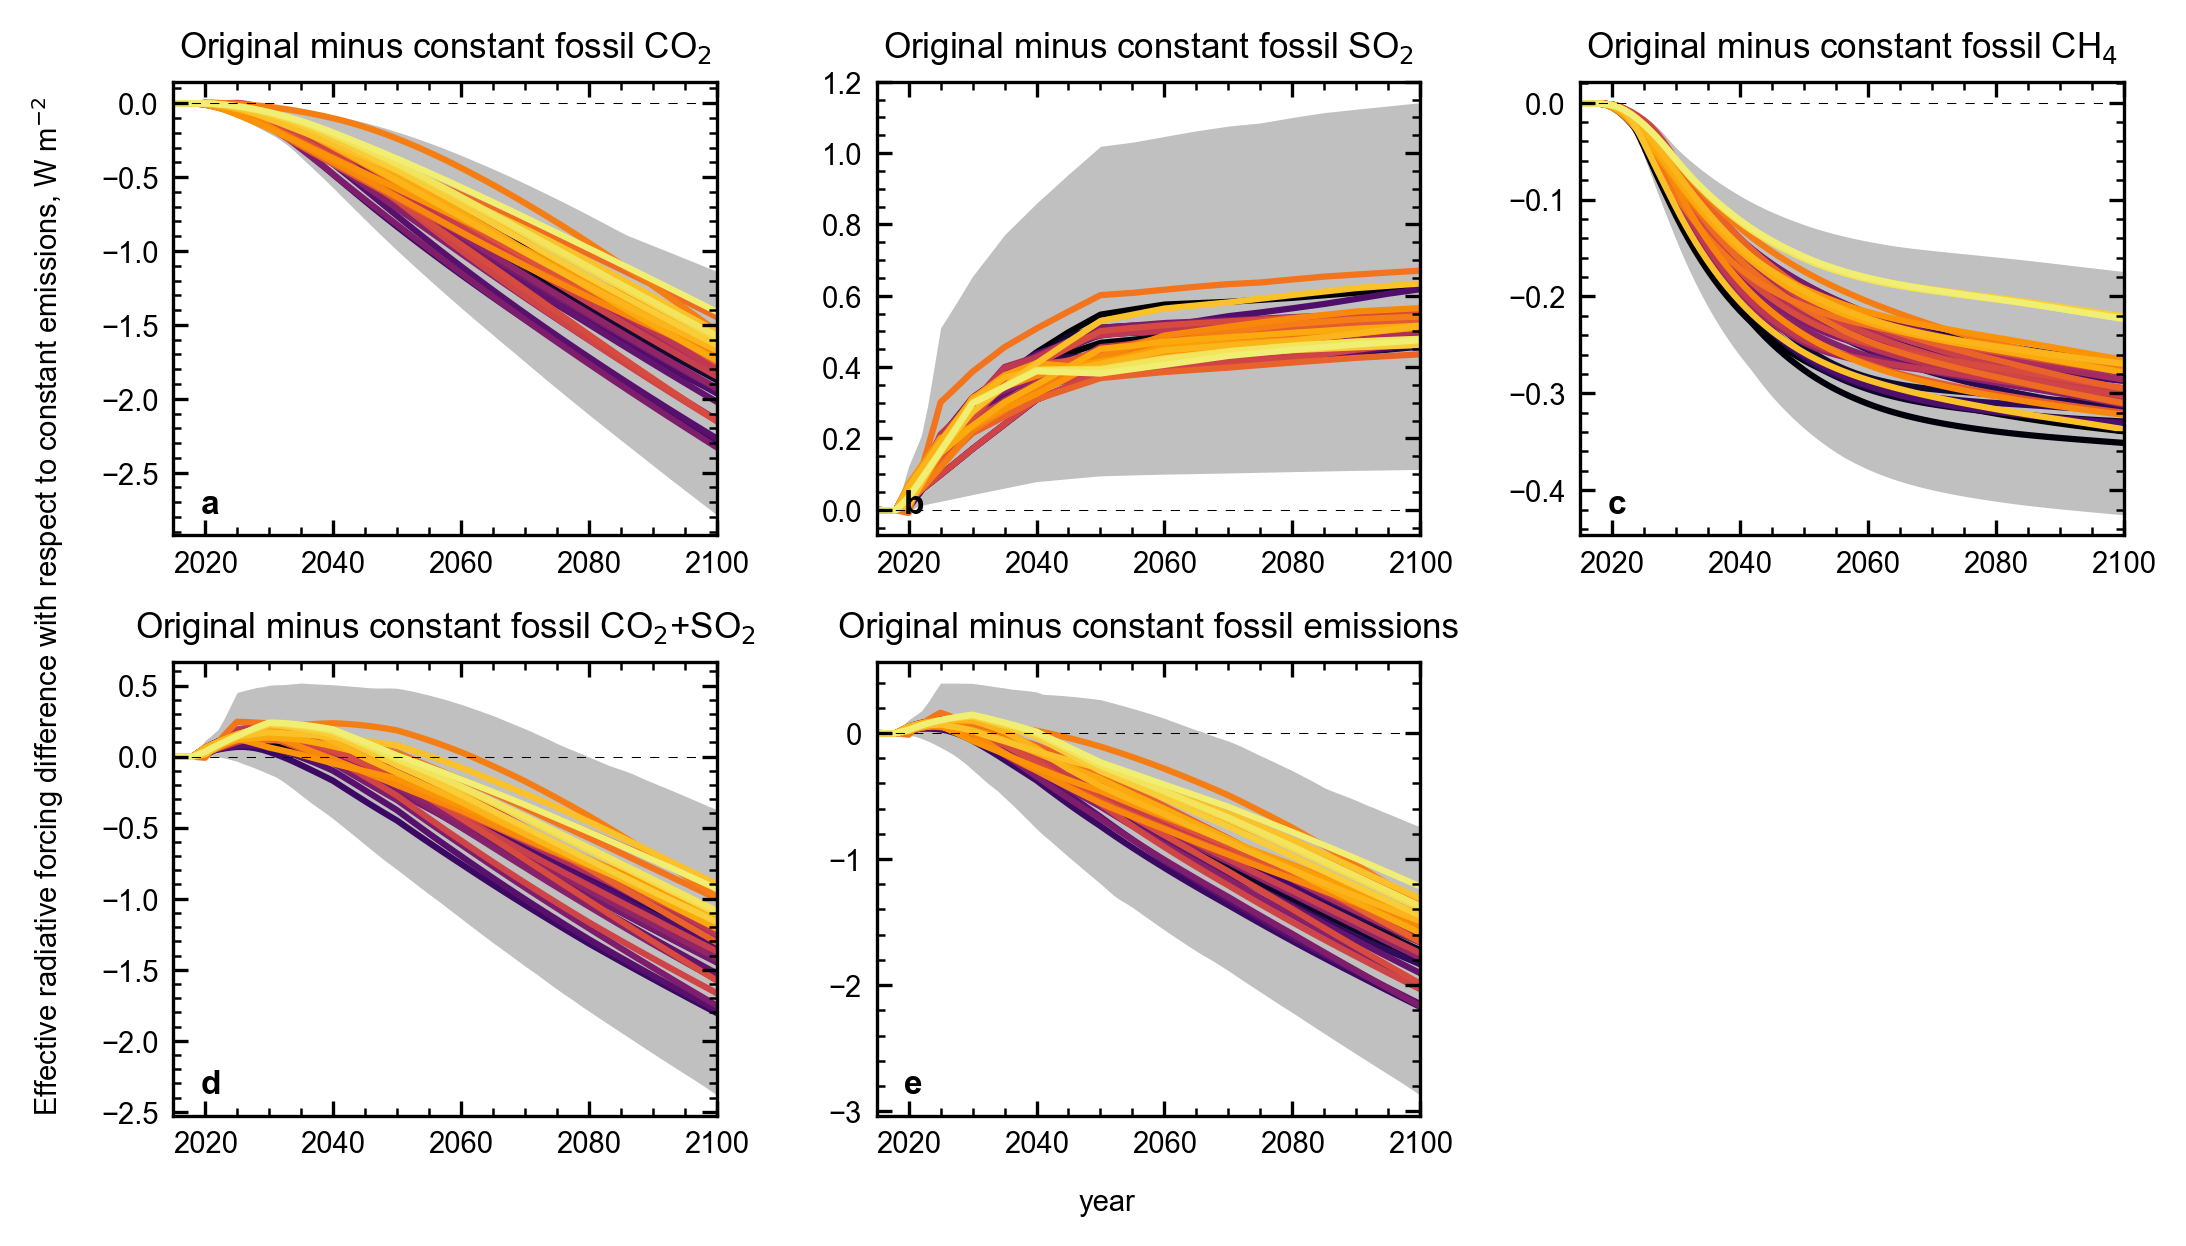

In [21]:
experiments = ['constant_co2', 'constant_so2', 'constant_ch4', 'constant_co2so2', 'constant_all']
fig = pl.figure(figsize=(18.3/2.54,10.3/2.54))
gs = gridspec.GridSpec(2, 3)
ax = [''] * 5
ax[0] = pl.subplot(gs[0, 0])
ax[1] = pl.subplot(gs[0, 1])
ax[2] = pl.subplot(gs[0, 2])
ax[3] = pl.subplot(gs[1, 0])
ax[4] = pl.subplot(gs[1, 1])

#fig,ax=pl.subplots(1,3,figsize=(16,5))
for j, experiment in enumerate(experiments):
    forcing_delta[experiment] = {}
    for i, label in enumerate(scenarios.keys()):
        forcing_delta[experiment][label] = {}
        nc = Dataset('output_data/%s/%s.nc' % (experiment,label))
        F2 = np.sum(nc.variables['forc'][:], axis=1)
        nc.close()
        nc = Dataset('output_data/original/%s.nc' % (label))
        F1 = np.sum(nc.variables['forc'][:], axis=1)
        nc.close()
        forcing_delta[experiment][label]['Mean'] = np.mean(F2-F1, axis=1)
        (
            forcing_delta[experiment][label]['P5'],
            forcing_delta[experiment][label]['Median'],
            forcing_delta[experiment][label]['P66'],
            forcing_delta[experiment][label]['P90'],
            forcing_delta[experiment][label]['P95'],
        ) = np.percentile(F2-F1, (5,50,66,90,95), axis=1)


max_95_3d = np.zeros(len(labels_sorted))
max_mean_3d = np.zeros(len(labels_sorted))
max_95_3e = np.zeros(len(labels_sorted))
max_mean_3e = np.zeros(len(labels_sorted))
max_95_3dnew = np.zeros(len(labels_sorted))
max_mean_3dnew = np.zeros(len(labels_sorted))
max_95_3enew = np.zeros(len(labels_sorted))
max_mean_3enew = np.zeros(len(labels_sorted))

p95_3a = np.zeros((101, len(labels_sorted)))
p95_3b = np.zeros((101, len(labels_sorted)))
p95_3c = np.zeros((101, len(labels_sorted)))
p95_3d = np.zeros((101, len(labels_sorted)))
p95_3e = np.zeros((101, len(labels_sorted)))
p05_3a = np.zeros((101, len(labels_sorted)))
p05_3b = np.zeros((101, len(labels_sorted)))
p05_3c = np.zeros((101, len(labels_sorted)))
p05_3d = np.zeros((101, len(labels_sorted)))
p05_3e = np.zeros((101, len(labels_sorted)))

for i, label in enumerate(labels_sorted):
    delta_co2 = -forcing_delta['constant_co2'][label]['Mean'][235:]
    delta_so2 = -forcing_delta['constant_so2'][label]['Mean'][235:]
    delta_ch4 = -forcing_delta['constant_ch4'][label]['Mean'][235:]
    delta_cds = -forcing_delta['constant_co2so2'][label]['Mean'][235:]
    delta_all = -forcing_delta['constant_all'][label]['Mean'][235:]
    
    delta_co2_05 = -forcing_delta['constant_co2'][label]['P5'][235:]
    delta_so2_05 = -forcing_delta['constant_so2'][label]['P5'][235:]
    delta_ch4_05 = -forcing_delta['constant_ch4'][label]['P5'][235:]
    delta_cds_05 = -forcing_delta['constant_co2so2'][label]['P5'][235:]
    delta_all_05 = -forcing_delta['constant_all'][label]['P5'][235:]

    delta_co2_95 = -forcing_delta['constant_co2'][label]['P95'][235:]
    delta_so2_95 = -forcing_delta['constant_so2'][label]['P95'][235:]
    delta_ch4_95 = -forcing_delta['constant_ch4'][label]['P95'][235:]
    delta_cds_95 = -forcing_delta['constant_co2so2'][label]['P95'][235:]
    delta_all_95 = -forcing_delta['constant_all'][label]['P95'][235:]
    
    p95_3a[:,i] = delta_co2_95
    p95_3b[:,i] = delta_so2_95
    p95_3c[:,i] = delta_ch4_95
    p95_3d[:,i] = delta_cds_95
    p95_3e[:,i] = delta_all_95
    p05_3a[:,i] = delta_co2_05
    p05_3b[:,i] = delta_so2_05
    p05_3c[:,i] = delta_ch4_05
    p05_3d[:,i] = delta_cds_05
    p05_3e[:,i] = delta_all_05
    
    ax[0].plot(np.arange(2000,2101), delta_co2, label=label, color=labels_colors[label])
    ax[1].plot(np.arange(2000,2101), delta_so2, label=label, color=labels_colors[label])
    ax[2].plot(np.arange(2000,2101), delta_ch4, label=label, color=labels_colors[label])
    ax[3].plot(np.arange(2000,2101), delta_cds, label=label, color=labels_colors[label])
    ax[4].plot(np.arange(2000,2101), delta_all, label=label, color=labels_colors[label])

# more care needed when compensating effects
top3a = reduce(np.maximum, (np.max(p05_3a, axis=1), np.max(p95_3a, axis=1), np.min(p05_3a, axis=1), np.min(p95_3a, axis=1)))
bot3a = reduce(np.minimum, (np.min(p05_3a, axis=1), np.min(p95_3a, axis=1), np.max(p05_3a, axis=1), np.max(p95_3a, axis=1)))
top3b = reduce(np.maximum, (np.max(p05_3b, axis=1), np.max(p95_3b, axis=1), np.min(p05_3b, axis=1), np.min(p95_3b, axis=1)))
bot3b = reduce(np.minimum, (np.min(p05_3b, axis=1), np.min(p95_3b, axis=1), np.max(p05_3b, axis=1), np.max(p95_3b, axis=1)))
top3c = reduce(np.maximum, (np.max(p05_3c, axis=1), np.max(p95_3c, axis=1), np.min(p05_3c, axis=1), np.min(p95_3c, axis=1)))
bot3c = reduce(np.minimum, (np.min(p05_3c, axis=1), np.min(p95_3c, axis=1), np.max(p05_3c, axis=1), np.max(p95_3c, axis=1)))
top3d = reduce(np.maximum, (np.max(p05_3d, axis=1), np.max(p95_3d, axis=1), np.min(p05_3d, axis=1), np.min(p95_3d, axis=1)))
bot3d = reduce(np.minimum, (np.min(p05_3d, axis=1), np.min(p95_3d, axis=1), np.max(p05_3d, axis=1), np.max(p95_3d, axis=1)))
top3e = reduce(np.maximum, (np.max(p05_3e, axis=1), np.max(p95_3e, axis=1), np.min(p05_3e, axis=1), np.min(p95_3e, axis=1)))
bot3e = reduce(np.minimum, (np.min(p05_3e, axis=1), np.min(p95_3e, axis=1), np.max(p05_3e, axis=1), np.max(p95_3e, axis=1)))

ax[0].fill_between(np.arange(2000,2101), bot3a, top3a, color='#c0c0c0', linewidth=0)
ax[1].fill_between(np.arange(2000,2101), bot3b, top3b, color='#c0c0c0', linewidth=0)
ax[2].fill_between(np.arange(2000,2101), bot3c, top3c, color='#c0c0c0', linewidth=0)
ax[3].fill_between(np.arange(2000,2101), bot3d, top3d, color='#c0c0c0', linewidth=0)
ax[4].fill_between(np.arange(2000,2101), bot3e, top3e, color='#c0c0c0', linewidth=0)

ax[0].set_title('Original minus constant fossil CO$_2$')
ax[1].set_title('Original minus constant fossil SO$_2$')
ax[2].set_title('Original minus constant fossil CH$_4$')
ax[3].set_title('Original minus constant fossil CO$_2$+SO$_2$')
ax[4].set_title('Original minus constant fossil emissions')

ax[0].set_xlim(2015,2100);
ax[1].set_xlim(2015,2100);
ax[2].set_xlim(2015,2100);
ax[3].set_xlim(2015,2100);
ax[4].set_xlim(2015,2100);

ax[0].axhline(0, color='k', ls=':', lw=0.25)
ax[1].axhline(0, color='k', ls=':', lw=0.25)
ax[2].axhline(0, color='k', ls=':', lw=0.25)
ax[3].axhline(0, color='k', ls=':', lw=0.25)
ax[4].axhline(0, color='k', ls=':', lw=0.25)

letters = ['a', 'b', 'c', 'd', 'e']
for i in range(5):
    ax[i].text(0.05,0.05,letters[i], weight='bold', size=8, transform=ax[i].transAxes);

pl.figtext(0.01,0.5,'Effective radiative forcing difference with respect to constant emissions, W m$^{-2}$',rotation=90,va='center', ha='center');
pl.figtext(0.5,0.01,'year',ha='center',va='center');
fig.tight_layout(rect=[0.02,0.02,1,1])
pl.savefig('figures/figS5.png')
pl.savefig('figures/figS5.pdf')

## Plot supplementary figure 4

### Geophysical uncertainty

This shows the ECS/TCR and aerosol forcing at IPCC AR5 95th percentile. We also plot the ensemble mean for comparison.

- ECS = 6.0
- TCR = 2.7 (45% of ECS is on the low but plausible side, based on CMIP5 models, and a higher TCR will make it difficult to recreate historical temperature change)
- aerosol forcing scaled to be -1.9 W/m2 in 2011 = scale factor of 2.2 over the default of -0.9 W/m2.

Choosing a 95th percentile ECS and TCR requires a value judgement. AR5 did not give an actual distribution shape (unlike they did for aerosol forcing), only a "likely" (> 66%) range. AR5 states it is "extremely unlikely" (5% or less probability) that TCR > 3K, whereas ECS could take higher values ("very unlikely" e.g. 10% or less chance of being over 6K). However, ECS is not important for the magnitude of near term (next ~20 years) climate change, and we choose 6.0K to keep the realised warming fraction (TCR/ECS) at 0.45, at the lower end of that seen in CMIP5 models. It is also observed that 6.0K and 2.7K is higher than the ECS and TCR of every CMIP5 model (see Forster et al., 2013), although 6.0K might be closer to the "earth system" sensitivity.

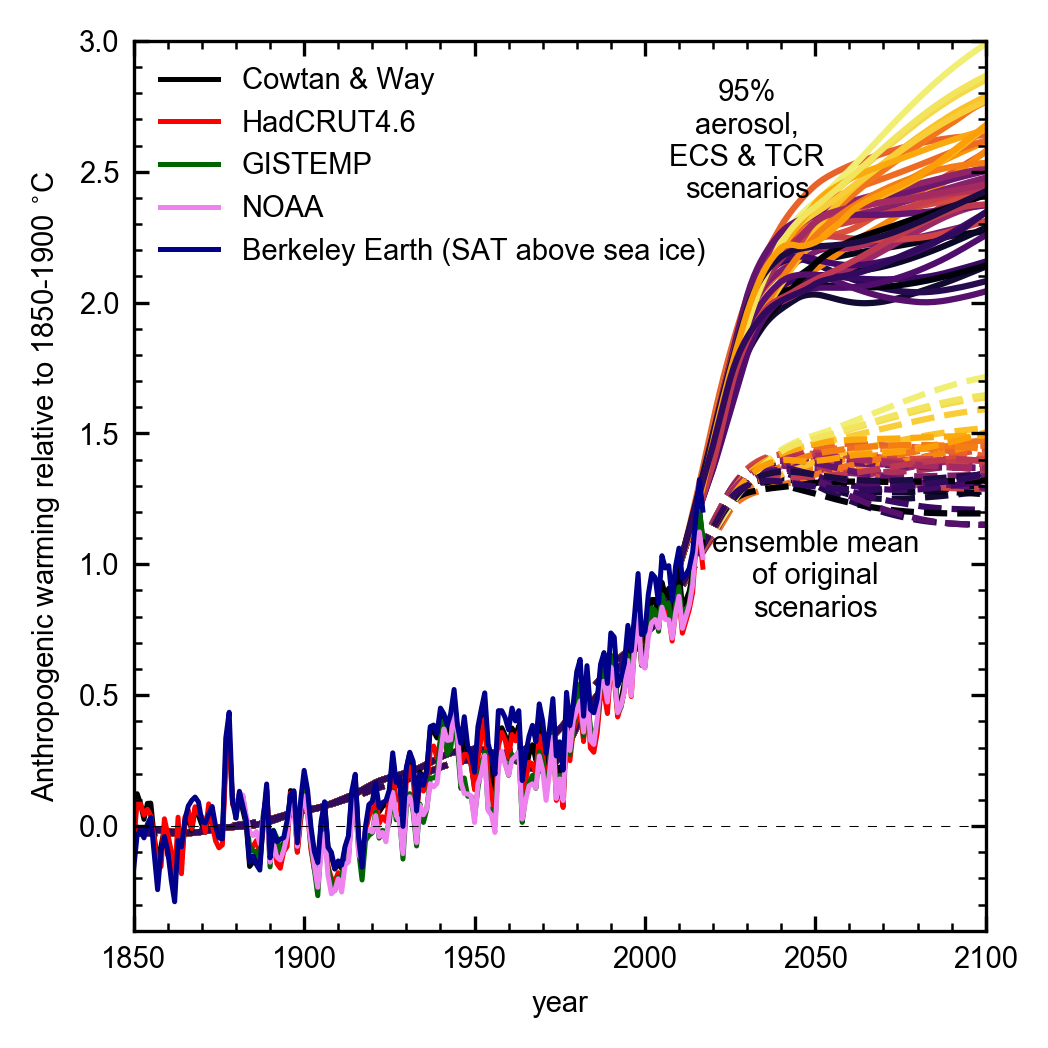

In [22]:
# original scenarios with a 95% setup
fig, ax = pl.subplots(figsize=(8.9/2.54,8.9/2.54))

obs = {}

# http://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_annual_v2_0_0.txt
data = np.loadtxt('input_data/temperature_observations/had4_krig_annual_v2_0_0.txt')
obs['Cowtan and Way'] = data[:,1] - np.mean(data[:51,1])

# https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg.txt
data = np.loadtxt('input_data/temperature_observations/HadCRUT.4.6.0.0.annual_ns_avg.txt')
obs['HadCRUT4.6'] = data[:-1,1] - np.mean(data[:51,1])

# https://data.giss.nasa.gov/gistemp/tabledata_v3/GLB.Ts+dSST.csv
data = np.genfromtxt('input_data/temperature_observations/GLB.Ts+dSST.csv', delimiter=',', skip_header=2, skip_footer=1)#, usecols=13)
obs['GISTEMP'] = data[:,13] - np.mean(data[:21,13])

# ftp://ftp.ncdc.noaa.gov/pub/data/noaaglobaltemp/operational/timeseries/aravg.ann.land_ocean.90S.90N.v4.0.1.201810.asc
data = np.loadtxt('input_data/temperature_observations/aravg.ann.land_ocean.90S.90N.v4.0.1.201810.asc')
obs['NOAA'] = data[:-1,1] - np.mean(data[:21,1])

# http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_summary.txt
data = np.loadtxt('input_data/temperature_observations/Land_and_Ocean_summary.txt', comments='%', skiprows=1)
obs['Berkeley (SAT above sea ice)'] = data[:,1] - np.mean(data[:51,1])

for i, label in enumerate(scenarios.keys()):
    scenarios[label]['Temperature'] = {}
    Fscale = np.ones(13)
    Fscale[8] = 2.2
    thisE = np.zeros((336, 40))
    thisE[:, 1] = scenarios[label]['BECCS'] + scenarios[label]['Enhanced Weathering']
    thisE = thisE + scenarios[label]['Emissions'][:nt,:]
    thisC, thisF, thisT = fair_scm(
        emissions      = thisE,
        tcrecs         = [2.7,6.0],
        F_volcanic     = 0.0,
        F_solar        = 0.0,
        natural        = nat[:nt,:],
        r0             = 35.0,
        rt             = 4.165,
        rc             = 0.019,
        d              = [220., 4.1],
        F2x            = 3.71,
        scale          = Fscale,
        tcr_dbl        = tcr_dbl,
        aviNOx_frac    = avi[:nt],
        fossilCH4_frac = ch4[:nt],
        efficacy       = efficacy,
        scaleHistoricalAR5=True,
    )
    # rebase output temperature to 1850-1900 mean
    scenarios[label]['Temperature']['default_P95'] = thisT - np.mean(thisT[85:136])
    
    ax.plot(np.arange(1850,2101), scenarios[label]['Temperature']['default_P95'][85:], color=labels_colors[label])
    ax.plot(np.arange(1850,2101), display_temps['original'][label]['Mean'][85:], color=labels_colors[label], ls='--')

ax.plot(np.arange(1850,2018), obs['Cowtan and Way'], color='k', lw=1.2, label='Cowtan & Way')
ax.plot(np.arange(1850,2018), obs['HadCRUT4.6'], color='red', lw=1.2, label='HadCRUT4.6')
ax.plot(np.arange(1880,2018), obs['GISTEMP'], color='darkgreen', lw=1.2, label='GISTEMP')
ax.plot(np.arange(1880,2018), obs['NOAA'], color='violet', lw=1.2, label='NOAA')
ax.plot(np.arange(1850,2018), obs['Berkeley (SAT above sea ice)'], color='darkblue', lw=1.2, label='Berkeley Earth (SAT above sea ice)')

ax.set_xlabel('year');
ax.set_ylabel('Anthropogenic warming relative to 1850-1900 $^{\circ}$C');
ax.set_xlim(1850,2100);
ax.set_ylim(-0.4,3.0);

ax.text(2030, 2.4, '95%\naerosol,\nECS & TCR\nscenarios', ha='center')
ax.text(2050, 0.8, 'ensemble mean\nof original\nscenarios', ha='center')
ax.axhline(0, color='k', ls=':', lw=0.25)

ax.legend(frameon=False);

pl.tight_layout()
pl.savefig('figures/figS4.png')
pl.savefig('figures/figS4.pdf')

Now use the same 95th percentile setup but take the difference of constant emissions and SR1.5 scenarios. This repeats figure 3e.

In [23]:
# constant fossil scenarios with a 95% setup
for i, label in enumerate(scenarios.keys()):
    Fscale = np.ones(13)
    Fscale[8] = 2.2
    thisE = np.zeros((336, 40))
    thisE[:, 1] = scenarios[label]['BECCS'] + scenarios[label]['Enhanced Weathering']
    thisE = thisE + scenarios[label]['Emissions'][:nt,:]
    thisE[254:,1] = thisE[253,1]
    thisE[254:,3] = thisE[253,3] * mean_fossil_fraction['CH4'][8] + thisE[254:,3] * (1. - mean_fossil_fraction['CH4'][9:])
    thisE[254:,5] = thisE[253,5] * mean_fossil_fraction['Sulfur'][8] + thisE[254:,5] * (1. - mean_fossil_fraction['Sulfur'][9:])
    thisE[254:,6] = thisE[253,6] * mean_fossil_fraction['CO'][6] + thisE[254:,6] * (1. - mean_fossil_fraction['CO'][9:])
    thisE[254:,7] = thisE[253,7] * mean_fossil_fraction['NOx'][8] + thisE[254:,7] * (1. - mean_fossil_fraction['NOx'][9:])
    thisE[254:,8] = thisE[253,8] * mean_fossil_fraction['VOC'][8] + thisE[254:,8] * (1. - mean_fossil_fraction['VOC'][9:])
    thisE[254:,9] = thisE[253,9] * mean_fossil_fraction['BC'][8] + thisE[254:,9] * (1. - mean_fossil_fraction['BC'][9:])
    thisE[254:,10] = thisE[253,10] * mean_fossil_fraction['OC'][8] + thisE[254:,10] * (1. - mean_fossil_fraction['OC'][9:])

    thisC, thisF, thisT = fair_scm(
        emissions      = thisE,
        tcrecs         = [2.7,6.0],
        F_volcanic     = 0.0,
        F_solar        = 0.0,
        natural        = nat[:nt,:],
        r0             = 35.0,
        rt             = 4.165,
        rc             = 0.019,
        d              = [220., 4.1],
        F2x            = 3.71,
        scale          = Fscale,
        tcr_dbl        = tcr_dbl,
        aviNOx_frac    = avi[:nt],
        fossilCH4_frac = ch4[:nt],
        efficacy       = efficacy,
        scaleHistoricalAR5=True,
    )
    # rebase output temperature to 1850-1900 mean
    scenarios[label]['Temperature']['constantfossil_2019_P95'] = thisT - np.mean(thisT[85:136])

## Plot supplementary figure 3

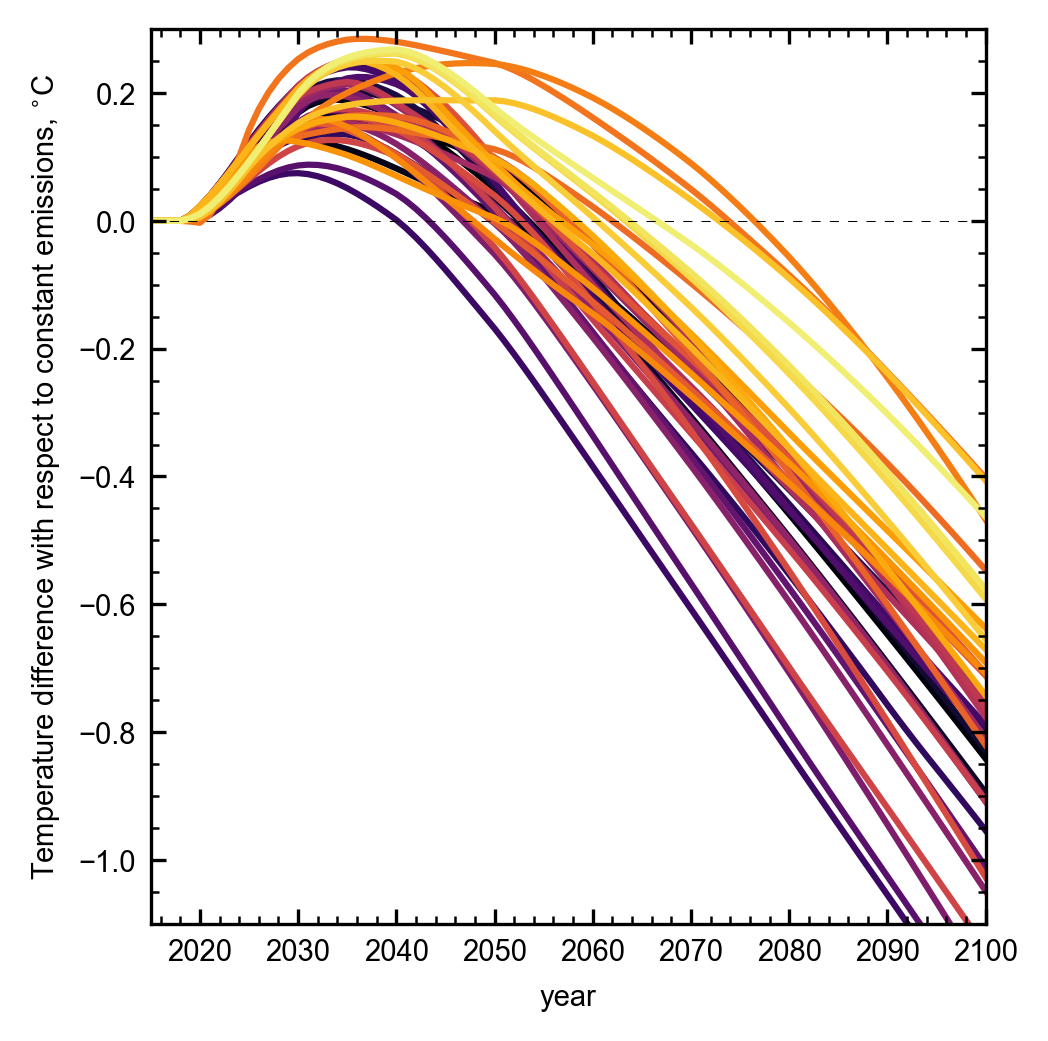

In [24]:
fig, ax = pl.subplots(figsize=(8.9/2.54,8.9/2.54))
max95 = np.zeros(len(labels_sorted))
for i, label in enumerate(labels_sorted):
    delta_fos_95 = scenarios[label]['Temperature']['default_P95'][235:] - scenarios[label]['Temperature']['constantfossil_2019_P95'][235:]
    ax.plot(np.arange(2000,2101), delta_fos_95, color=labels_colors[label], label=label);
    max95[i] = np.max(delta_fos_95)
    
ax.set_xlim(2015,2100)
ax.set_ylim(-1.1,0.3)

ax.set_xlabel('year');
ax.set_ylabel('Temperature difference with respect to constant emissions, $^{\circ}$C');
ax.axhline(0, color='k', ls=':', lw=0.25)

pl.tight_layout()
pl.savefig('figures/figS3.png')
pl.savefig('figures/figS3.pdf')

In [25]:
print "Maximum 'climate penalty' at 95th percentile setup: ", np.max(max95)

Maximum 'climate penalty' at 95th percentile setup:  0.284875253351


## Plot supplementary figure 8

The effect of the pre-Etminan methane forcing definition on our conclusions

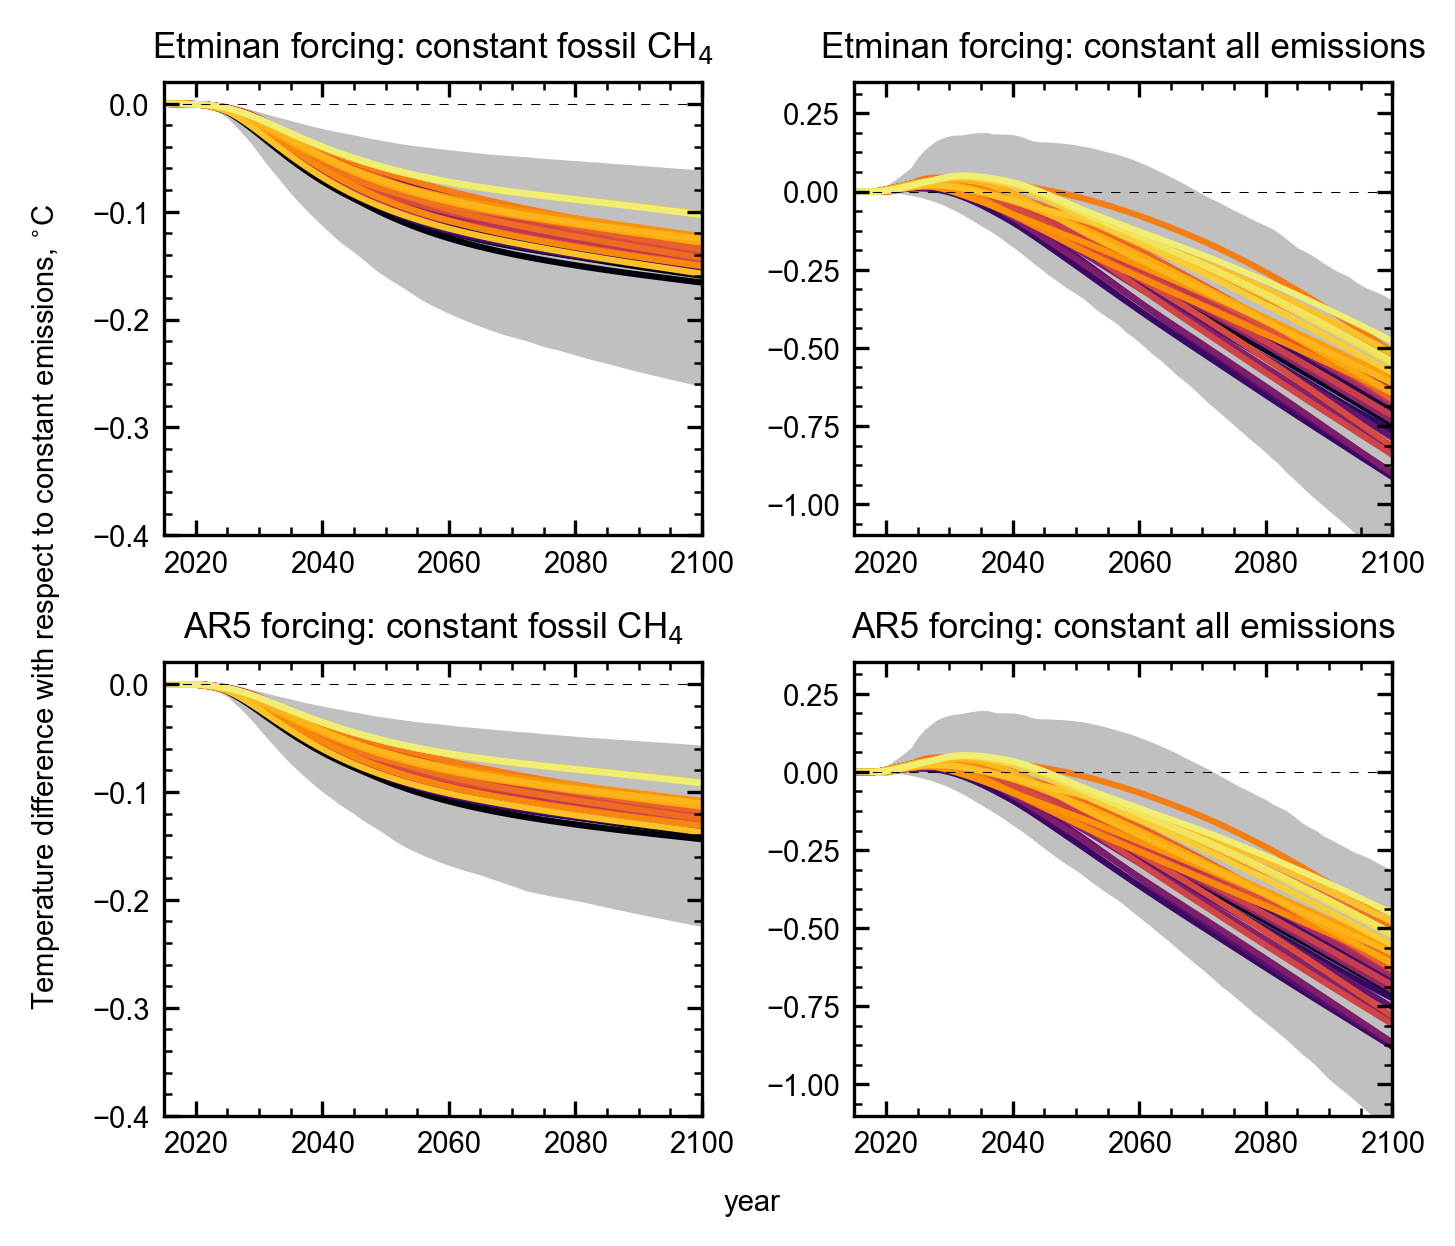

In [26]:
experiments = ['constant_ch4AR5', 'constant_allAR5']
fig = pl.figure(figsize=(12.2/2.54,10.3/2.54))
gs = gridspec.GridSpec(2, 2)
ax = [''] * 5
ax[0] = pl.subplot(gs[0, 0])
ax[1] = pl.subplot(gs[0, 1])
ax[2] = pl.subplot(gs[1, 0])
ax[3] = pl.subplot(gs[1, 1])

#fig,ax=pl.subplots(1,3,figsize=(16,5))
for j, experiment in enumerate(experiments):
    display_temps[experiment] = {}
    for i, label in enumerate(scenarios.keys()):
        display_temps[experiment][label] = {}
        nc = Dataset('output_data/%s/%s.nc' % (experiment,label))
        T2 = nc.variables['temp'][:] - np.mean(nc.variables['temp'][85:136,:], axis=0)
        nc.close()
        nc = Dataset('output_data/originalAR5/%s.nc' % (label))
        T1 = nc.variables['temp'][:] - np.mean(nc.variables['temp'][85:136,:], axis=0)
        nc.close()
        display_temps[experiment][label]['Mean'] = np.mean(T2-T1, axis=1)
        (
            display_temps[experiment][label]['P5'],
            display_temps[experiment][label]['Median'],
            display_temps[experiment][label]['P66'],
            display_temps[experiment][label]['P90'],
            display_temps[experiment][label]['P95'],
        ) = np.percentile(T2-T1, (5,50,66,90,95), axis=1)

p95_s5a = np.zeros((101, len(labels_sorted)))
p95_s5b = np.zeros((101, len(labels_sorted)))
p95_s5c = np.zeros((101, len(labels_sorted)))
p95_s5d = np.zeros((101, len(labels_sorted)))
p05_s5a = np.zeros((101, len(labels_sorted)))
p05_s5b = np.zeros((101, len(labels_sorted)))
p05_s5c = np.zeros((101, len(labels_sorted)))
p05_s5d = np.zeros((101, len(labels_sorted)))

for i, label in enumerate(labels_sorted):
    delta_ch4 = -display_temps['constant_ch4'][label]['Mean'][235:]
    delta_all = -display_temps['constant_all'][label]['Mean'][235:]
    delta_ch4ar5 = -display_temps['constant_ch4AR5'][label]['Mean'][235:]
    delta_allar5 = -display_temps['constant_allAR5'][label]['Mean'][235:]
    
    delta_ch4_05 = -display_temps['constant_ch4'][label]['P5'][235:]
    delta_all_05 = -display_temps['constant_all'][label]['P5'][235:]
    delta_ch4ar5_05 = -display_temps['constant_ch4AR5'][label]['P5'][235:]
    delta_allar5_05 = -display_temps['constant_allAR5'][label]['P5'][235:]

    delta_ch4_95 = -display_temps['constant_ch4'][label]['P95'][235:]
    delta_all_95 = -display_temps['constant_all'][label]['P95'][235:]
    delta_ch4ar5_95 = -display_temps['constant_ch4AR5'][label]['P95'][235:]
    delta_allar5_95 = -display_temps['constant_allAR5'][label]['P95'][235:]
    
    p95_s5a[:,i] = delta_ch4_95
    p95_s5b[:,i] = delta_all_95
    p95_s5c[:,i] = delta_ch4ar5_95
    p95_s5d[:,i] = delta_allar5_95
    p05_s5a[:,i] = delta_ch4_05
    p05_s5b[:,i] = delta_all_05
    p05_s5c[:,i] = delta_ch4ar5_05
    p05_s5d[:,i] = delta_allar5_05
    
    ax[0].plot(np.arange(2000,2101), delta_ch4, label=label, color=labels_colors[label])
    ax[1].plot(np.arange(2000,2101), delta_all, label=label, color=labels_colors[label])
    ax[2].plot(np.arange(2000,2101), delta_ch4ar5, label=label, color=labels_colors[label])
    ax[3].plot(np.arange(2000,2101), delta_allar5, label=label, color=labels_colors[label])

# more care needed when compensating effects
tops5a = reduce(np.maximum, (np.max(p05_s5a, axis=1), np.max(p95_s5a, axis=1), np.min(p05_s5a, axis=1), np.min(p95_s5a, axis=1)))
bots5a = reduce(np.minimum, (np.min(p05_s5a, axis=1), np.min(p95_s5a, axis=1), np.max(p05_s5a, axis=1), np.max(p95_s5a, axis=1)))
tops5b = reduce(np.maximum, (np.max(p05_s5b, axis=1), np.max(p95_s5b, axis=1), np.min(p05_s5b, axis=1), np.min(p95_s5b, axis=1)))
bots5b = reduce(np.minimum, (np.min(p05_s5b, axis=1), np.min(p95_s5b, axis=1), np.max(p05_s5b, axis=1), np.max(p95_s5b, axis=1)))
tops5c = reduce(np.maximum, (np.max(p05_s5c, axis=1), np.max(p95_s5c, axis=1), np.min(p05_s5c, axis=1), np.min(p95_s5c, axis=1)))
bots5c = reduce(np.minimum, (np.min(p05_s5c, axis=1), np.min(p95_s5c, axis=1), np.max(p05_s5c, axis=1), np.max(p95_s5c, axis=1)))
tops5d = reduce(np.maximum, (np.max(p05_s5d, axis=1), np.max(p95_s5d, axis=1), np.min(p05_s5d, axis=1), np.min(p95_s5d, axis=1)))
bots5d = reduce(np.minimum, (np.min(p05_s5d, axis=1), np.min(p95_s5d, axis=1), np.max(p05_s5d, axis=1), np.max(p95_s5d, axis=1)))

ax[0].fill_between(np.arange(2000,2101), bots5a, tops5a, color='#c0c0c0', linewidth=0)
ax[1].fill_between(np.arange(2000,2101), bots5b, tops5b, color='#c0c0c0', linewidth=0)
ax[2].fill_between(np.arange(2000,2101), bots5c, tops5c, color='#c0c0c0', linewidth=0)
ax[3].fill_between(np.arange(2000,2101), bots5d, tops5d, color='#c0c0c0', linewidth=0)
    
ax[0].set_title('Etminan forcing: constant fossil CH$_4$')
ax[1].set_title('Etminan forcing: constant all emissions')
ax[2].set_title('AR5 forcing: constant fossil CH$_4$')
ax[3].set_title('AR5 forcing: constant all emissions')

ax[0].set_xlim(2015,2100);
ax[1].set_xlim(2015,2100);
ax[2].set_xlim(2015,2100);
ax[3].set_xlim(2015,2100);

ax[0].set_ylim(-0.4,0.02);
ax[1].set_ylim(-1.1,0.35);
ax[2].set_ylim(-0.4,0.02);
ax[3].set_ylim(-1.1,0.35);

ax[0].axhline(0, color='k', ls=':', lw=0.25)
ax[1].axhline(0, color='k', ls=':', lw=0.25)
ax[2].axhline(0, color='k', ls=':', lw=0.25)
ax[3].axhline(0, color='k', ls=':', lw=0.25)

pl.figtext(0.01,0.5,'Temperature difference with respect to constant emissions, $^{\circ}$C',rotation=90,va='center', ha='center');
pl.figtext(0.5,0.01,'year',ha='center',va='center');
fig.tight_layout(rect=[0.02,0.02,1,1])
pl.savefig('figures/figS8.png')
pl.savefig('figures/figS8.pdf')

## Plot supplementary figure 6

The variation in instantaneous airborne fraction as a function of time versus that derived from observations from the Global Carbon Project to demonstrate that FaIR correctly simulates the long term average ariborne fraction originally in response to a reviewer question, later added as a supplementary plot.

Data is used from the 2018 Global Carbon Budget: Le Quéré, C., Andrew, R. M., Friedlingstein, P., Sitch, S., Hauck, J., Pongratz, J., Pickers, P. A., Korsbakken, J. I., Peters, G. P., Canadell, J. G., Arneth, A., Arora, V. K., Barbero, L., Bastos, A., Bopp, L., Chevallier, F., Chini, L. P., Ciais, P., Doney, S. C., Gkritzalis, T., Goll, D. S., Harris, I., Haverd, V., Hoffman, F. M., Hoppema, M., Houghton, R. A., Hurtt, G., Ilyina, T., Jain, A. K., Johannessen, T., Jones, C. D., Kato, E., Keeling, R. F., Goldewijk, K. K., Landschützer, P., Lefèvre, N., Lienert, S., Liu, Z., Lombardozzi, D., Metzl, N., Munro, D. R., Nabel, J. E. M. S., Nakaoka, S., Neill, C., Olsen, A., Ono, T., Patra, P., Peregon, A., Peters, W., Peylin, P., Pfeil, B., Pierrot, D., Poulter, B., Rehder, G., Resplandy, L., Robertson, E., Rocher, M., Rödenbeck, C., Schuster, U., Schwinger, J., Séférian, R., Skjelvan, I., Steinhoff, T., Sutton, A., Tans, P. P., Tian, H., Tilbrook, B., Tubiello, F. N., van der Laan-Luijkx, I. T., van der Werf, G. R., Viovy, N., Walker, A. P., Wiltshire, A. J., Wright, R., Zaehle, S., and Zheng, B.: Global Carbon Budget 2018, Earth Syst. Sci. Data, 10, 2141–2194, https://doi.org/10.5194/essd-10-2141-2018, 2018. 

Data available from https://data.icos-cp.eu/licence_accept?ids=%5B%22OT_YY6iORypk2yAcwjMpUQpo%22%5D

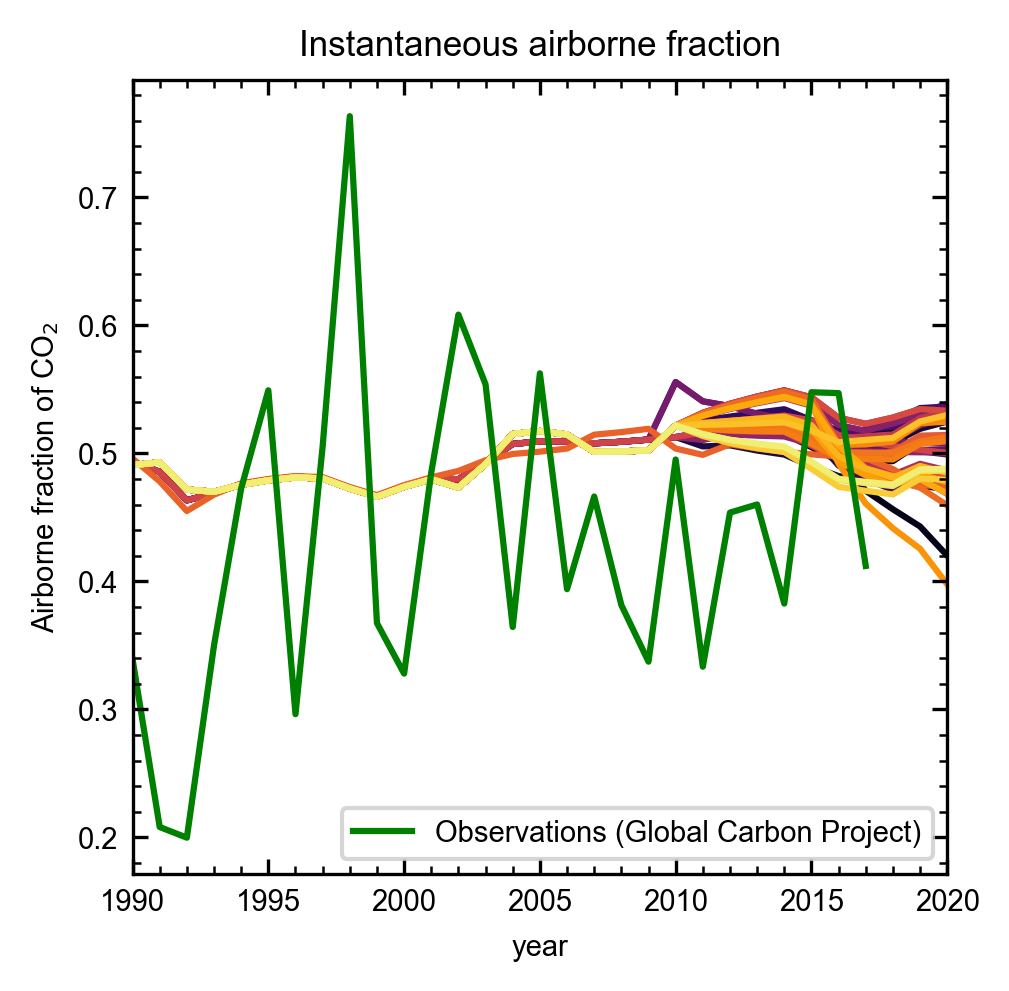

In [27]:
gcp = np.loadtxt('input_data/global_carbon_project/gcp2018.txt', skiprows=1)
af = gcp[:,3]/np.sum(gcp[:,1:3], axis=1)

fig, ax = pl.subplots(figsize=(8.9/2.54,8.9/2.54))

for label in labels_sorted:
    E = np.sum(scenarios[label]['Emissions'][:nt,1:3], axis=1)
    C = np.concatenate(([0], np.diff(np.median(scenarios[label]['concentrations']['CO2'], axis=1)) * ppm_gtc))
    ax.plot(np.arange(1990,2021), C[225:256]/E[225:256], color=labels_colors[label])

ax.plot(np.arange(1990,2018), af, color='green', label='Observations (Global Carbon Project)')
ax.set_xlim(1990,2020);
ax.set_xlabel('year')
ax.set_ylabel('Airborne fraction of CO$_2$')
ax.set_title('Instantaneous airborne fraction')
ax.legend()

pl.savefig('figures/figS6.png')
pl.savefig('figures/figS6.pdf')